<a href="https://colab.research.google.com/github/hseguraq/Proyecto-Integrador-ITESM-MNAV/blob/main/Avance3_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo Base**
# **Radiografías de Tórax**
# ITESM - MNA V

## Proyecto Integrador - TC5035.10

## Profesora: Dra. Grettel Barceló Alonso


### Equipo 19

Héctor Segura Quintanilla (A01154108)

Julio César García Escoto (A01795050)

Francisco Medellín Zertuche (A01794044)


# Introducción

*Abstract de los procesos a realizar*



# **FALTA:**
* ENTRENAR CON IMÁGENES NO SEGMENTADAS (SOLO PASADAS A GREYSCALE) - **LISTO**
* AGREGAR GRÁFICOS DE DESEMPEÑO (solo para entrenamiento) - **LISTO**
* AGREGAR VISUALIZACIÓN PARA LA MATRIZ DE CONFUSIÓN - **LISTO**
* INTEGRAR GRADCAM PARA VISUALIZAR IMPORTANCIA ESPACIAL (ÚTIL PERO OPCIONAL)
* INDAGAR QUÉ FILTROS AFECTAN MÁS INTERNAMENTE (FEATURE ATTRIBUTION POR CANAL O POR CAPA)

# **RESPONDER**

* ¿El modelo está sub/sobreajustando los datos de entrenamiento?
* ¿Cuál es la métrica adecuada para este problema de negocio?
* ¿Cuál debería ser el desempeño mínimo a obtener?

In [1]:
!pip install -q scikit-image
!pip install -q ImageHash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 10.2 MB/s eta 0:00:00


In [2]:
import os
import random
import math
import shutil
import multiprocessing
from datetime import datetime
from glob import glob
from collections import Counter
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm # Mantener tqdm.auto para notebooks
from IPython.display import Image, display

# Image Processing (PIL, OpenCV)
from PIL import Image
from PIL.Image import Resampling
import cv2
import imagehash

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from keras.utils import to_categorical # Añadido ya que se usa para Y_encoded

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Metrics
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, average_precision_score)

# Multiprocessing pipeline
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
from datetime import datetime
from tensorflow.keras.utils import to_categorical

In [3]:
# CREAMOS UNA CLASE QUE NOS AYUDARA A CARGAR LOS DATOS PARA LOS MODELOS (UTILIZA EL FORMATO DE DATASET GENERADO EN EL PUNTO 5)
# ESTA CLASE ADAPTA LAS RUTAS RELATIVAS A RUTAS ABSOLUTAS DEL ENTORNO DE EJECUCIÓN
class DatasetLoader:
    """
    Carga y prepara los DataFrames de entrenamiento, validación y prueba
    desde archivos CSV contenidos en una carpeta específica.
    """

    def __init__(self, dataset_path: str):
        """
        Inicializa el cargador de datasets con la ruta base de la carpeta.

        Args:
            dataset_path (str): La ruta absoluta o relativa a la carpeta
                                 que contiene los archivos CSV (train.csv,
                                 val.csv, test.csv).
        """
        # Normaliza la ruta y la guarda
        self.dataset_path = os.path.abspath(dataset_path)
        print(f"Ruta base del dataset establecida: {self.dataset_path}")

    def _load_and_process_df(self, filename: str) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Método interno para cargar un CSV específico, preprocesar las rutas
        y dividir el DataFrame en X (rutas de imagen) y Y (etiquetas).

        Args:
            filename (str): Nombre del archivo CSV (ej. 'train.csv').

        Returns:
            tuple[pd.DataFrame, pd.DataFrame]: Una tupla con (X, Y) DataFrames.
        """
        file_path = os.path.join(self.dataset_path, filename)

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"El archivo '{filename}' no se encontró en la ruta: {file_path}")

        df = pd.read_csv(file_path)

        # Verificar que las columnas 'image_path' y 'label' existan
        if 'image_path' not in df.columns or 'label' not in df.columns:
            raise ValueError(f"El archivo '{filename}' debe contener las columnas 'image_path' y 'label'.")

        print(f"Archivo {filename} leído. Filas: {len(df)}")

        df['image_path'] = df['image_path'].apply(
            lambda x: os.path.join(self.dataset_path, x)
        )

        # Dividir el DataFrame
        # X: solo la columna 'image_path'
        X = df[['image_path']]
        # Y: solo la columna 'label'
        Y = df[['label']]

        return X, Y


    def get_dataframes(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Carga y procesa los tres archivos CSV (train, val, test) y regresa
        seis DataFrames (X_train, X_val, X_test, Y_train, Y_val, Y_test).

        Returns:
            tuple: (x_train, x_val, x_test, y_train, y_val, y_test)
        """
        print("\nIniciando carga y preprocesamiento de DataFrames...")

        # Cargar y procesar el conjunto de entrenamiento
        x_train, y_train = self._load_and_process_df('train.csv')

        # Cargar y procesar el conjunto de validación
        x_val, y_val = self._load_and_process_df('val.csv')

        # Cargar y procesar el conjunto de prueba
        x_test, y_test = self._load_and_process_df('test.csv')

        print("\nCarga de DataFrames completada exitosamente.")

        # Regresar los 6 DataFrames
        return x_train, x_val, x_test, y_train, y_val, y_test

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# CARGAMOS LOS DATASET GENERADOS EN EL PUNTO 5 A UNA VARIABLE (SE CARGAN DESDE EL ALMACENAMIENTO PARA NO RECREAR LOS SPLIT EN CADA EJECUCIÓN)
dt_loader = DatasetLoader('/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og')
x_train_og, x_val_og, x_test_og, y_train_og, y_val_og, y_test_og = dt_loader.get_dataframes()

# dt_loader_crop = DatasetLoader('/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_crop')
# x_train_crop, x_val_crop, x_test_crop, y_train_crop, y_val_crop, y_test_crop = dt_loader_crop.get_dataframes()

Ruta base del dataset establecida: /content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/dataset_og

Iniciando carga y preprocesamiento de DataFrames...
Archivo train.csv leído. Filas: 579
Archivo val.csv leído. Filas: 124
Archivo test.csv leído. Filas: 125

Carga de DataFrames completada exitosamente.


In [6]:
class ImageVersioner:
    """
    Clase para crear y ejecutar un pipeline de procesamiento de imágenes
    unificada y optimizada con paralelismo. VERSIÓN CORREGIDA.
    """
    def __init__(self, initial_params=None, stepVersioning=True, max_workers=multiprocessing.cpu_count()):
        self.initial_params = initial_params if initial_params is not None else {}
        self.step_versioning = stepVersioning
        self.pipeline_steps = []
        self.max_workers = max_workers
        self.class_mapping = {
            'Normal': 0, 'ASD': 1, 'PDA': 2, 'VSD': 3
        }
        self.num_classes = len(self.class_mapping)
        self.inverse_class_mapping = {v: k for k, v in self.class_mapping.items()}

    def createPipeline(self, steps: list):
        self.pipeline_steps = steps
        print(f"Pipeline creado con {len(steps)} pasos.")

    @staticmethod
    def _save_versioned_image_static(image, base_path, step_name, original_filename, log_enabled):
        step_dir = os.path.join(base_path, step_name)
        os.makedirs(step_dir, exist_ok=True)
        save_path = os.path.join(step_dir, original_filename)
        image.save(save_path)
        if log_enabled:
            print(f"  -> Imagen guardada en: {save_path}")

    @staticmethod
    def _process_static(row_data, index, pipeline_steps, initial_params, base_path, step_versioning, log): # <--- CAMBIO CLAVE: Recibe el índice
        """
        Función de procesamiento estática. Retorna una tupla (índice, PIL.Image).
        """
        image_path = row_data['image_path']
        original_filename = os.path.basename(image_path)
        if log:
            print(f"\nProcesando imagen: {original_filename}")
        try:
            current_image = Image.open(image_path).convert("RGB")
            if step_versioning:
                ImageVersioner._save_versioned_image_static(current_image, base_path, "00_original", original_filename, log)
            for step_name, step_function in pipeline_steps:
                current_image = step_function(current_image, **initial_params)
                if step_versioning:
                    ImageVersioner._save_versioned_image_static(current_image, base_path, step_name, original_filename, log)

            # <--- CAMBIO CLAVE: Retorna el índice junto con la imagen
            return (index, current_image)
        except Exception as e:
            tqdm.write(f"Error procesando {original_filename}: {e}")
            return (index, None) # <--- CAMBIO CLAVE: Retorna el índice incluso en error

    def pipeline(self, data_df: pd.DataFrame, versioning_root_path: str, label: str, log: bool = False) -> np.ndarray:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        version_folder = f"{label}_{timestamp}"
        base_path = os.path.join(versioning_root_path, version_folder)
        os.makedirs(base_path, exist_ok=True)
        print(f"Iniciando pipeline y versionado en: {base_path} con {self.max_workers} procesos paralelos.")

        # <--- CAMBIO CLAVE: Guardará tuplas (índice, imagen)
        processing_results = []

        with ProcessPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [
                executor.submit(self._process_static,
                                row,
                                index, # <--- CAMBIO CLAVE: Pasa el índice original
                                self.pipeline_steps,
                                self.initial_params,
                                base_path,
                                self.step_versioning,
                                log)
                for index, row in data_df.iterrows()
            ]

            iterator = tqdm(as_completed(futures), total=len(futures), desc=f"Procesando {label}", disable=log)

            for future in iterator:
                result_tuple = future.result()
                if result_tuple[1] is not None: # Checa si la imagen no es None
                    processing_results.append(result_tuple)

            if not log:
                iterator.close()

        # <--- CAMBIO CLAVE: Reordenar los resultados según el índice original
        print("\nReordenando resultados...")
        processing_results.sort(key=lambda x: x[0])

        # <--- CAMBIO CLAVE: Extraer solo las imágenes, ahora en el orden correcto
        final_images_pil_list = [img for idx, img in processing_results]

        print("Convirtiendo a tensor y normalizando...")
        if not final_images_pil_list:
            print("Advertencia: No se procesó ninguna imagen.")
            return np.array([])

        x_np_list = [np.array(img, dtype='uint8') for img in final_images_pil_list]
        x_tensor = np.stack(x_np_list, axis=0)

        if len(x_tensor.shape) == 3:
            x_tensor = np.expand_dims(x_tensor, axis=-1)

        x_normalized = x_tensor.astype('float32') / 255.0

        print(f"Pipeline finalizado. Tensor X generado con forma: {x_normalized.shape}")
        return x_normalized

    def transform_y_encoded(self, y_df: pd.DataFrame) -> np.ndarray:
        if 'label' not in y_df.columns:
            raise ValueError("El DataFrame de etiquetas debe contener la columna 'label'.")
        y_integers = y_df['label'].map(self.class_mapping)
        if y_integers.isnull().any():
            unmapped_labels = y_df['label'][y_integers.isnull()].unique()
            raise ValueError(f"Se encontraron etiquetas no definidas en el mapeo: {unmapped_labels}")
        y_encoded = to_categorical(y_integers, num_classes=self.num_classes)
        print(f"Etiquetas codificadas generadas con forma: {y_encoded.shape}")
        return y_encoded

In [7]:
# Funciones Auxiliares

def _pil_to_cv2_gray(image_pil):
    """Convierte PIL (L o RGB) a NumPy/CV2 en escala de grises."""
    img_gray_pil = image_pil.convert('L')
    return np.array(img_gray_pil)

def _cv2_gray_to_pil(img_cv):
    """Convierte NumPy/CV2 (escala de grises) a PIL."""
    return Image.fromarray(img_cv)

#-----FUNCIONES VERSIONABLES-------

def step_convert_to_grayscale(image_pil, **kwargs):
    """0. Convierte la imagen a escala de grises (modo 'L' en PIL)."""
    return image_pil.convert('L')

# Función para convertir a escala de grises y redimensionar imagen sin pérdidas
def step_grayscale_and_safe_resize(img, size=320, pad_mode='median', **kwargs):
    """
    Acepta PIL.Image o np.ndarray y devuelve PIL.Image 'L' (size x size).
    Mantiene aspecto: reescala y rellena (letterbox) con la mediana (o 0).
    """
    # 1) Normalizar entrada a PIL
    if isinstance(img, Image.Image):
        pil = img
    elif isinstance(img, np.ndarray):
        arr = img
        # convertir a uint8 si viene float
        if arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8) if arr.max() > 1.5 else (np.clip(arr,0,1)*255).astype(np.uint8)
        if arr.ndim == 3 and arr.shape[2] >= 3:
            pil = Image.fromarray(arr[..., :3])              # RGB
        elif arr.ndim == 2:
            pil = Image.fromarray(arr, mode='L')             # gray
        else:
            pil = Image.fromarray(arr.squeeze())             # fallback
    else:
        raise TypeError(f"Tipo no soportado: {type(img)}")

    # 2) A escala de grises
    g = pil.convert('L')  # 1 canal

    # 3) Resize manteniendo aspecto + letterbox a (size,size)
    w, h = g.size
    if w == 0 or h == 0:
        raise ValueError(f"Tamaño inválido: {g.size}")
    scale = min(size / w, size / h)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    g_res = g.resize((new_w, new_h), Image.BILINEAR)

    # Fondo por mediana (o 0)
    arr_res = np.asarray(g_res, dtype=np.uint8)
    pad_val = int(np.median(arr_res)) if pad_mode == 'median' else 0

    canvas = Image.new('L', (size, size), color=pad_val)
    x0 = (size - new_w) // 2
    y0 = (size - new_h) // 2
    canvas.paste(g_res, (x0, y0))  # PIL.Image.paste

    # 4) Devolver PIL.Image para que ImageVersioner pueda .save()
    return canvas


def step_remove_marker_inpaint(image_pil, **kwargs):
    """1. Quita marcadores circulares mediante detección Hough e inpainting."""

    img_gray = _pil_to_cv2_gray(image_pil)

    # Lógica original de remove_marker_inpaint (simplificada para el pipeline)
    g = cv2.medianBlur(img_gray, 5)
    circles = cv2.HoughCircles(
        g, cv2.HOUGH_GRADIENT, dp=1.2, minDist=kwargs.get('minDist', 60),
        param1=kwargs.get('param1', 120), param2=kwargs.get('param2', 35),
        minRadius=kwargs.get('minRadius', 10), maxRadius=kwargs.get('maxRadius', 60)
    )
    mask = np.zeros_like(img_gray, dtype=np.uint8)

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        h, w = img_gray.shape
        # Usamos el parámetro configurable 'head_frac' para el límite vertical si existe
        vertical_limit = int(h * kwargs.get('marker_v_limit', 0.45))

        for x, y, r in circles:
            if y < vertical_limit:
                cv2.circle(mask, (x, y), int(r * kwargs.get('marker_scale', 1.25)), 255, -1)

    if mask.any():
        final_img_cv = cv2.inpaint(img_gray, mask, 3, cv2.INPAINT_TELEA)
    else:
        final_img_cv = img_gray.copy()

    return _cv2_gray_to_pil(final_img_cv)


def step_crop_and_resize(image_pil, **kwargs):
    """
    2. Segmenta tórax, calcula BBox, recorta cabeza/abdomen y aplica fit-to-square.
    Esta función agrupa los sub-pasos: thorax_mask, bbox_from_mask, trim_head_abdomen,
    crop_to_bbox, y fit_to_square.
    """

    # --- 0. Inicialización ---
    img_gray = _pil_to_cv2_gray(image_pil)
    no_marker = img_gray # Asumimos que esta imagen ya fue limpiada en un paso anterior
    h, w = img_gray.shape

    # --- 1. Sub-función: thorax_mask (Segmenta tórax) ---

    def _thorax_mask(img_gray_in):
        """Segmenta tórax (máscara binaria robusta)."""
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        ce = clahe.apply(img_gray_in)
        inv = cv2.bitwise_not(ce)

        _, th = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((5,5), np.uint8), iterations=1)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((15,15), np.uint8), iterations=1)

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=8)
        h_in, w_in = img_gray_in.shape
        cx_allowed = (int(w_in*0.15), int(w_in*0.85))
        candidate_idx = []
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            cx, cy = centroids[i]
            if area > 0.002 * (h_in*w_in) and cx_allowed[0] <= cx <= cx_allowed[1]:
                candidate_idx.append((area, i))

        mask_out = np.zeros_like(th)
        for _, i in sorted(candidate_idx, reverse=True)[:3]:
            mask_out[labels == i] = 255

        if not mask_out.any():
            if num_labels > 1:
                i = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                mask_out[labels == i] = 255

        contours, _ = cv2.findContours(mask_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hull_mask = np.zeros_like(mask_out)
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            cv2.drawContours(hull_mask, [hull], -1, 255, -1)

        return cv2.dilate(hull_mask, np.ones((7,7), np.uint8), iterations=1)

    mask = _thorax_mask(no_marker)

    # --- 2. Sub-función: bbox_from_mask (Calcula BBox) ---

    def _bbox_from_mask(mask_in, tighten=kwargs.get('bbox_tighten', 0.02)):
        """BBox apretado a partir de máscara."""
        ys, xs = np.where(mask_in > 0)
        if len(xs) == 0:
            return (0, 0, mask_in.shape[1], mask_in.shape[0])
        x0, x1 = xs.min(), xs.max()
        y0, y1 = ys.min(), ys.max()
        w_in = x1 - x0 + 1
        h_in = y1 - y0 + 1
        x0 += int(w_in * tighten); x1 -= int(w_in * tighten)
        y0 += int(h_in * tighten); y1 -= int(h_in * tighten)
        x0 = max(x0, 0); y0 = max(y0, 0)
        x1 = min(x1, mask_in.shape[1]-1); y1 = min(y1, mask_in.shape[0]-1)
        return (x0, y0, x1, y1)

    x0, y0, x1, y1 = _bbox_from_mask(mask)

    # --- 3. Ajuste Lateral (shrink) ---

    w = x1 - x0 + 1
    shrink_frac = kwargs.get('shrink_frac', 0.10)
    shrink = int(w * shrink_frac)
    x0 = x0 + shrink
    x1 = x1 - shrink
    x1 = max(x1, x0 + 1) # Asegurar ancho mínimo

    # --- 4. Sub-función: trim_head_abdomen (Recorte vertical) ---

    def _trim_head_abdomen(y0_in, y1_in, h_in, head_frac=kwargs.get('head_frac', 0.1), abdomen_frac=kwargs.get('abdomen_frac', 0.20)):
        """Recorta cabeza/abdomen por fracciones verticales."""
        y0_new = max(y0_in, int(h_in * head_frac))
        y1_new = min(y1_in, int(h_in * (1.0 - abdomen_frac)))
        if y1_new <= y0_new:
            return y0_in, y1_in
        return y0_new, y1_new

    y0, y1 = _trim_head_abdomen(y0, y1, h)
    bbox = (x0, y0, x1, y1)

    # --- 5. Sub-función: crop_to_bbox (Recorte final) ---

    def _crop_to_bbox(img_in, bbox_in):
        """Recorta imagen al bbox."""
        x0_in, y0_in, x1_in, y1_in = bbox_in
        return img_in[y0_in:y1_in+1, x0_in:x1_in+1]

    cropped = _crop_to_bbox(no_marker, bbox)

    # --- 6. Sub-función: fit_to_square (Normalización de tamaño) ---

    def _fit_to_square(img_in, size=kwargs.get('size', 320), pad_mode=kwargs.get('pad_mode', "median")):
        """Redimensiona con aspecto y centra en lienzo cuadrado."""
        h_in, w_in = img_in.shape[:2]
        if h_in == 0 or w_in == 0:
             return np.zeros((size, size), dtype=img_in.dtype) # Devuelve negro si está vacío

        scale = min(size / w_in, size / h_in)
        nw, nh = int(round(w_in * scale)), int(round(h_in * scale))

        interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
        resized = cv2.resize(img_in, (nw, nh), interpolation=interp)

        canvas = np.zeros((size, size), dtype=img_in.dtype) # Inicializa a negro (constant)

        if pad_mode == "median":
            # Usar la mediana del array redimensionado
            fill = int(np.median(resized))
            canvas.fill(fill)

        # Colocar centrado
        top  = (size - nh) // 2
        left = (size - nw) // 2
        canvas[top:top+nh, left:left+nw] = resized

        # (Lógica de 'replicate' omitida por brevedad, pero puedes incluirla aquí)

        return canvas

    final_img_cv = _fit_to_square(cropped)

    # --- 7. Conversión final y Retorno ---
    return _cv2_gray_to_pil(final_img_cv)


In [8]:

transformation_steps = [
    ("0_grayscale_convert", step_convert_to_grayscale),
    ("1_remove_marker_inpaint", step_remove_marker_inpaint),
    ("2_crop_and_resize", step_crop_and_resize),
]

initial_params = {
    # Parámetros de step_remove_marker_inpaint
    'minDist': 60,
    'param2': 35,
    'marker_v_limit': 0.45,
    'marker_scale': 1.25,

    # Parámetros de step_crop_and_resize
    'bbox_tighten': 0.02,
    'shrink_frac': 0.10,
    'head_frac': 0.1,
    'abdomen_frac': 0.20,
    'size': 320,
    'pad_mode': 'median',
}


# Inicialización y Asignación del Pipeline

# Inicializamos la clase, habilitando el versionado de cada paso
imv = ImageVersioner(
    initial_params=initial_params,
    stepVersioning=True
)

# Asignamos las funciones al pipeline interno
imv.createPipeline(transformation_steps)

# Ejecución del Pipeline y Generación de Tensores X Normalizados

print("INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)")

# X_train: Ejecuta, versiona los resultados y devuelve un array (N, 320, 320, 1) normalizado [0, 1].
X_train_normalized = imv.pipeline(
    data_df=x_train_og,
    versioning_root_path='DataVersioning_Output',
    label='TrainOG',
    log=False
)

# X_test
X_test_normalized = imv.pipeline(
    data_df=x_test_og,
    versioning_root_path='DataVersioning_Output',
    label='TestOG',
    log=False
)

# X_val
X_val_normalized = imv.pipeline(
    data_df=x_val_og,
    versioning_root_path='DataVersioning_Output',
    label='ValOG',
    log=False
)

# --- 4. Codificación de Etiquetas (Generación de Tensores Y Codificados) ---

print("INICIANDO CODIFICACIÓN DE ETIQUETAS (GENERACIÓN DE Y)")
# Y_train: Convierte el DataFrame de etiquetas a One-Hot Encoding.
Y_train_encoded = imv.transform_y_encoded(y_train_og)

# Y_test
Y_test_encoded = imv.transform_y_encoded(y_test_og)

# Y_val
Y_val_encoded = imv.transform_y_encoded(y_val_og)


# --- 5. Resultados Listos para el Modelo ---

print("RESUMEN DE TENSORES LISTOS")
print(f"X_train (imágenes normalizadas): {X_train_normalized.shape}")
print(f"Y_train (etiquetas codificadas): {Y_train_encoded.shape}")
print(f"X_val   (imágenes normalizadas): {X_val_normalized.shape}")
print(f"Y_val   (etiquetas codificadas): {Y_val_encoded.shape}")
print(f"X_test  (imágenes normalizadas): {X_test_normalized.shape}")
print(f"Y_test  (etiquetas codificadas): {Y_test_encoded.shape}")

#SIGUIENTES PASOS PARA LOS MODELOS
# model.fit(x_train_normalized, y_train_encoded, epochs=..., validation_data=...)




Pipeline creado con 3 pasos.
INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)
Iniciando pipeline y versionado en: DataVersioning_Output/TrainOG_20251013_010651 con 2 procesos paralelos.


Procesando TrainOG:   0%|          | 0/579 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (579, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/TestOG_20251013_010945 con 2 procesos paralelos.


Procesando TestOG:   0%|          | 0/125 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (125, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/ValOG_20251013_011022 con 2 procesos paralelos.


Procesando ValOG:   0%|          | 0/124 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (124, 320, 320, 1)
INICIANDO CODIFICACIÓN DE ETIQUETAS (GENERACIÓN DE Y)
Etiquetas codificadas generadas con forma: (579, 4)
Etiquetas codificadas generadas con forma: (125, 4)
Etiquetas codificadas generadas con forma: (124, 4)
RESUMEN DE TENSORES LISTOS
X_train (imágenes normalizadas): (579, 320, 320, 1)
Y_train (etiquetas codificadas): (579, 4)
X_val   (imágenes normalizadas): (124, 320, 320, 1)
Y_val   (etiquetas codificadas): (124, 4)
X_test  (imágenes normalizadas): (125, 320, 320, 1)
Y_test  (etiquetas codificadas): (125, 4)


# **ENTRENAMIENTO CON PIPELINE COMPLETO**

In [9]:
history_crop = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # registro de LR por batch
}

In [10]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- Datos: X_*_normalized (N,320,320,1) en [0,1]; Y_*_encoded one-hot (N,4) ----
num_classes = Y_train_encoded.shape[1]
y_train_idx = Y_train_encoded.argmax(1).astype(np.int64)
y_val_idx   = Y_val_encoded.argmax(1).astype(np.int64)
y_test_idx  = Y_test_encoded.argmax(1).astype(np.int64)

# Normalización por dataset (rápida): media y std del canal gris
def chan_stats(x):
    m = float(x.mean()); s = float(x.std() + 1e-8)
    return m, s
mean_tr, std_tr = chan_stats(X_train_normalized[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

class NumpyGrayDataset(Dataset):
    def __init__(self, x_nhwc, y_idx, mean, std):
        self.x = np.transpose(x_nhwc, (0,3,1,2)).astype(np.float32, copy=False)  # NCHW (N,1,320,320)
        # normalizar a (x - mean)/std
        self.x = (self.x - mean) / std
        self.y = y_idx.astype(np.int64)
    def __len__(self): return self.x.shape[0]
    def __getitem__(self, i):
        return torch.from_numpy(self.x[i]), torch.tensor(self.y[i])

BATCH = 64
dl_train = DataLoader(NumpyGrayDataset(X_train_normalized, y_train_idx, mean_tr, std_tr),
                      batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
dl_val   = DataLoader(NumpyGrayDataset(X_val_normalized,   y_val_idx,   mean_tr, std_tr),
                      batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_test  = DataLoader(NumpyGrayDataset(X_test_normalized,  y_test_idx,  mean_tr, std_tr),
                      batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# ---- Modelo: ResNet18 desde cero, adaptada a 1 canal, con cabeza regularizada ----
class ResNet18Gray(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        m = models.resnet18(weights=None)
        # adaptar conv1 a 1 canal
        old = m.conv1
        m.conv1 = nn.Conv2d(1, old.out_channels, kernel_size=old.kernel_size,
                            stride=old.stride, padding=old.padding, bias=False)
        nn.init.kaiming_normal_(m.conv1.weight, mode='fan_out', nonlinearity='relu')
        in_feats = m.fc.in_features
        m.fc = nn.Sequential(
            nn.Dropout(p=0.35),
            nn.Linear(in_feats, num_classes)
        )
        self.net = m
    def forward(self, x): return self.net(x)

model = ResNet18Gray(num_classes).to(device)

# ---- Pérdida con label smoothing + optimizer + OneCycle ----
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 25
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())

def topk_acc(logits, y, k=1):
    _, pred = logits.topk(k, 1, True, True)
    return (pred.eq(y.view(-1,1)).any(1).float().mean().item())

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = total = a1 = a2 = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(xb)
                loss = criterion(logits, yb)
        bs = xb.size(0)
        total_loss += loss.item()*bs; total += bs
        a1 += topk_acc(logits, yb, 1)*bs; a2 += topk_acc(logits, yb, 2)*bs
    return total_loss/total, a1/total, a2/total

best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_crop["train_loss"].append(tr_loss); history_crop["train_acc"].append(tr_a1); history_crop["train_top2"].append(tr_a2)
    history_crop["val_loss"].append(va_loss);   history_crop["val_acc"].append(va_a1);   history_crop["val_top2"].append(va_a2)

    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best.pt")

# Save the last epoch
torch.save(model.state_dict(), "last.pt")



Device: cuda
Dataset norm: mean=0.5610, std=0.1811


/tmp/ipython-input-274917942.py:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-274917942.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.4109 acc 0.313 top2 0.582 | val 1.3986 acc 0.339 top2 0.516 | lr 1.35e-04


/tmp/ipython-input-274917942.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 02 | train 1.2304 acc 0.466 top2 0.724 | val 2.3602 acc 0.258 top2 0.516 | lr 3.83e-04
Epoch 03 | train 1.1626 acc 0.535 top2 0.803 | val 3.7554 acc 0.258 top2 0.556 | lr 6.86e-04
Epoch 04 | train 1.0429 acc 0.629 top2 0.855 | val 7.6890 acc 0.371 top2 0.597 | lr 9.22e-04
Epoch 05 | train 1.1936 acc 0.522 top2 0.770 | val 3.8141 acc 0.234 top2 0.524 | lr 1.00e-03
Epoch 06 | train 1.2518 acc 0.480 top2 0.736 | val 3.4018 acc 0.250 top2 0.605 | lr 9.93e-04
Epoch 07 | train 1.1242 acc 0.532 top2 0.824 | val 2.0654 acc 0.379 top2 0.581 | lr 9.73e-04
Epoch 08 | train 1.1174 acc 0.546 top2 0.807 | val 1.4955 acc 0.355 top2 0.605 | lr 9.42e-04
Epoch 09 | train 1.0109 acc 0.625 top2 0.869 | val 2.7516 acc 0.306 top2 0.637 | lr 9.00e-04
Epoch 10 | train 1.0350 acc 0.606 top2 0.839 | val 3.8074 acc 0.306 top2 0.605 | lr 8.48e-04
Epoch 11 | train 1.0901 acc 0.587 top2 0.841 | val 7.3650 acc 0.242 top2 0.524 | lr 7.88e-04
Epoch 12 | train 0.9753 acc 0.656 top2 0.870 | val 1.7710 acc 0.444 to

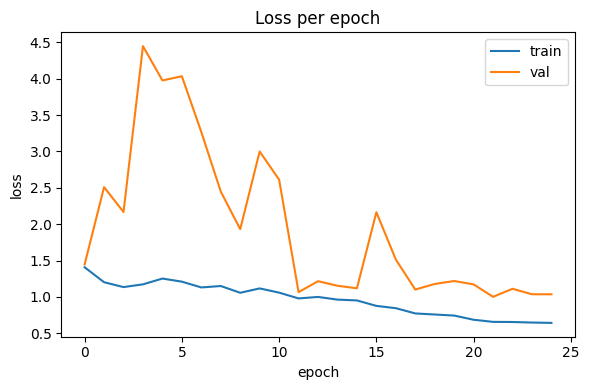

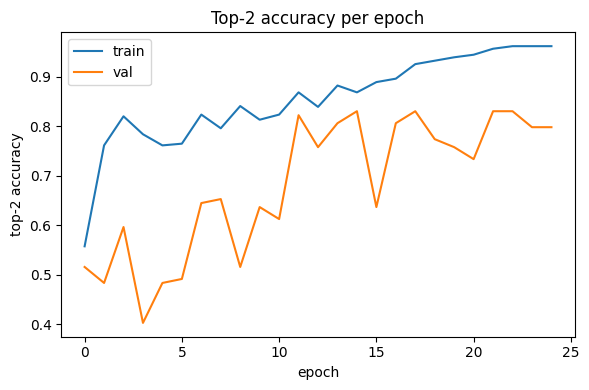

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_loss"], label="train")
plt.plot(history_crop["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_acc"], label="train")
plt.plot(history_crop["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_crop["train_top2"], label="train")
plt.plot(history_crop["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_crop["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_crop["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()


In [11]:
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 0) Carga el mejor modelo
model.load_state_dict(torch.load("best.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajusta el orden/nombres según tu label encoder
# Por ejemplo, si usaste este orden en el fit: ["ASD","Normal","PDA","VSD"]
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-443909943.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 0.9961171875, 'acc': 0.608, 'top2': 0.792}
              precision    recall  f1-score   support

         ASD     0.6562    0.6562    0.6562        32
      Normal     0.5600    0.4828    0.5185        29
         PDA     0.6552    0.5758    0.6129        33
         VSD     0.5641    0.7097    0.6286        31

    accuracy                         0.6080       125
   macro avg     0.6089    0.6061    0.6041       125
weighted avg     0.6108    0.6080    0.6060       125

[[21  4  2  5]
 [ 6 14  4  5]
 [ 2  5 19  7]
 [ 3  2  4 22]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


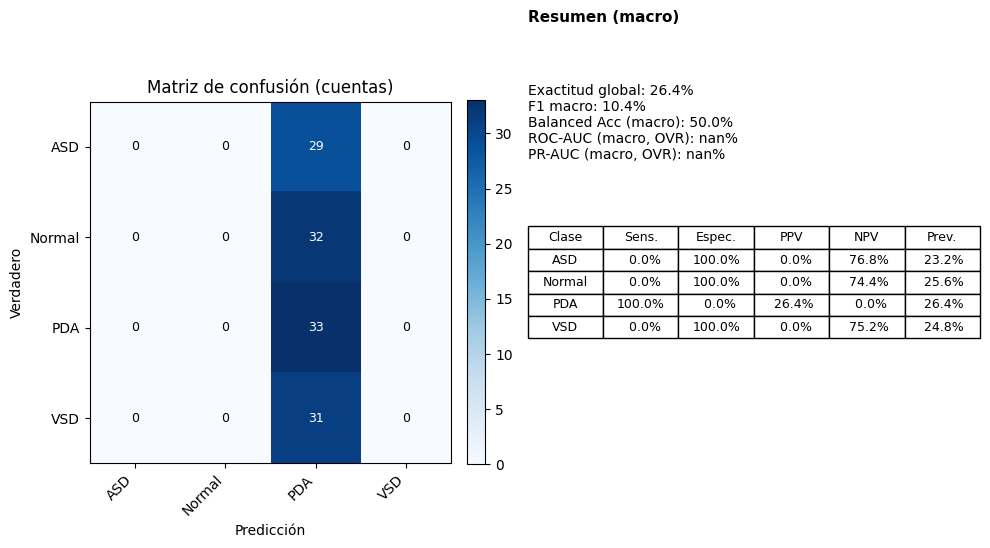

{'accuracy': 0.264, 'f1_macro': 0.10443037974683544, 'balanced_accuracy_macro': np.float64(0.4999999999999923), 'roc_auc_macro_ovr': nan, 'pr_auc_macro_ovr': nan}


In [ ]:
C = len(target_names)

# --- Métricas base ---
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# One-vs-rest AUCs
try:
    roc_auc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
except Exception:
    roc_auc_macro = np.nan
try:
    pr_auc_macro  = average_precision_score(
        np.eye(C)[y_true], y_prob, average='macro'
    )
except Exception:
    pr_auc_macro = np.nan

# Balanced Accuracy macro = promedio de (sensibilidad y especificidad por clase, OVR)
# Calculamos también Sensibilidad/Especificidad/PPV/NPV por clase
per_class_rows = []
sens_list, spec_list = [], []
ppv_list,  npv_list  = [], []
prev_list = []

total = cm.sum()
for k, name in enumerate(target_names):
    tp = cm[k, k]
    fn = cm[k, :].sum() - tp
    fp = cm[:, k].sum() - tp
    tn = total - tp - fp - fn

    sens = tp / (tp + fn + 1e-12)      # recall
    spec = tn / (tn + fp + 1e-12)
    ppv  = tp / (tp + fp + 1e-12)      # precision
    npv  = tn / (tn + fn + 1e-12)
    prev = (tp + fn) / (total + 1e-12)

    sens_list.append(sens); spec_list.append(spec)
    ppv_list.append(ppv);   npv_list.append(npv)
    prev_list.append(prev)

    per_class_rows.append([
        name,
        f"{sens*100:5.1f}%",
        f"{spec*100:5.1f}%",
        f"{ppv*100:5.1f}%",
        f"{npv*100:5.1f}%",
        f"{prev*100:5.1f}%"
    ])

balanced_acc_macro = np.mean([(s + p)/2 for s, p in zip(sens_list, spec_list)])

f1_macro = float(report["macro avg"]["f1-score"])
acc_overall = float(report["accuracy"])

# Visual: matriz de confusión + tabla de métricas
fig = plt.figure(figsize=(10, 5.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1.05, 1.2])

# Panel 1: Confusion Matrix (counts)
ax1 = fig.add_subplot(gs[0,0])
im = ax1.imshow(cm, cmap="Blues")
ax1.set_title("Matriz de confusión (cuentas)")
ax1.set_xlabel("Predicción"); ax1.set_ylabel("Verdadero")

ticks = np.arange(C)
ax1.set_xticks(ticks); ax1.set_yticks(ticks)
ax1.set_xticklabels(target_names, rotation=45, ha="right")
ax1.set_yticklabels(target_names)

# anotar celdas
th = cm.max() / 2
for i in range(C):
    for j in range(C):
        ax1.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black", fontsize=9)
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# Panel 2: Tabla de métricas clínicas clave
ax2 = fig.add_subplot(gs[0,1])
ax2.axis('off')
col_labels = ["Clase", "Sens.", "Espec.", "PPV", "NPV", "Prev."]
table_data = per_class_rows

table = ax2.table(cellText=table_data,
                  colLabels=col_labels,
                  loc='center',
                  cellLoc='center',
                  colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.0, 1.2)

# Encabezado de resumen macro
macro_text = (
    f"Exactitud global: {acc_overall*100:0.1f}%\n"
    f"F1 macro: {f1_macro*100:0.1f}%\n"
    f"Balanced Acc (macro): {balanced_acc_macro*100:0.1f}%\n"
    f"ROC-AUC (macro, OVR): {roc_auc_macro*100:0.1f}%\n"
    f"PR-AUC (macro, OVR): {pr_auc_macro*100:0.1f}%"
)
ax2.text(0.0, 1.05, "Resumen (macro)", fontsize=11, fontweight='bold', transform=ax2.transAxes)
ax2.text(0.0, 0.92, macro_text, fontsize=10, transform=ax2.transAxes, va='top')

plt.tight_layout()
plt.show()

# --- Impresión resumida en consola (opcional) ---
print({
    "accuracy": acc_overall,
    "f1_macro": f1_macro,
    "balanced_accuracy_macro": balanced_acc_macro,
    "roc_auc_macro_ovr": roc_auc_macro,
    "pr_auc_macro_ovr": pr_auc_macro
})

# **ENTRENAMIENTO CON PIPELINE PARCIAL (SOLO GREYSCALE)**



In [12]:
history_raw = {
    "train_loss": [], "train_acc": [], "train_top2": [],
    "val_loss":   [], "val_acc":   [], "val_top2":   [],
    "lrs": []  # per-batch LR track (for OneCycle)
}

In [13]:
transformation_steps = [
    ("0_grayscale_and_safe_resize", step_grayscale_and_safe_resize),
]

initial_params = {
    'size': 320,
    'pad_mode': 'median',
}

imv = ImageVersioner(initial_params=initial_params, stepVersioning=True)
imv.createPipeline(transformation_steps)

print("INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)")
X_train_raw = imv.pipeline(x_train_og, 'DataVersioning_Output', 'TrainOG', log=False)
X_test_raw = imv.pipeline(x_test_og,  'DataVersioning_Output', 'TestOG',  log=False)
X_val_raw = imv.pipeline(x_val_og,   'DataVersioning_Output', 'ValOG',   log=False)

print(X_train_normalized.shape, X_val_normalized.shape, X_test_normalized.shape)
# -> deberían ser (N, 320, 320, 1) en todos los casos


Pipeline creado con 1 pasos.
INICIANDO PROCESAMIENTO DE IMÁGENES (GENERACIÓN DE X)
Iniciando pipeline y versionado en: DataVersioning_Output/TrainOG_20251013_014212 con 2 procesos paralelos.


Procesando TrainOG:   0%|          | 0/579 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (579, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/TestOG_20251013_014228 con 2 procesos paralelos.


Procesando TestOG:   0%|          | 0/125 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (125, 320, 320, 1)
Iniciando pipeline y versionado en: DataVersioning_Output/ValOG_20251013_014232 con 2 procesos paralelos.


Procesando ValOG:   0%|          | 0/124 [00:00<?, ?it/s]


Reordenando resultados...
Convirtiendo a tensor y normalizando...
Pipeline finalizado. Tensor X generado con forma: (124, 320, 320, 1)
(579, 320, 320, 1) (124, 320, 320, 1) (125, 320, 320, 1)


In [14]:
mean_tr, std_tr = chan_stats(X_train_raw[..., 0])
print(f"Dataset norm: mean={mean_tr:.4f}, std={std_tr:.4f}")

BATCH = 64
dl_train = DataLoader(NumpyGrayDataset(X_train_raw, y_train_idx, mean_tr, std_tr),
                      batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
dl_val   = DataLoader(NumpyGrayDataset(X_val_raw,   y_val_idx,   mean_tr, std_tr),
                      batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
dl_test  = DataLoader(NumpyGrayDataset(X_test_raw,  y_test_idx,  mean_tr, std_tr),
                      batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

model = ResNet18Gray(num_classes).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
EPOCHS = 25
steps_per_epoch = len(dl_train)
scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, pct_start=0.2)

scaler = GradScaler(enabled=torch.cuda.is_available())


best_val = float('inf')
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_a1, tr_a2 = run_epoch(dl_train, train=True)
    va_loss, va_a1, va_a2 = run_epoch(dl_val,   train=False)

    history_raw["train_loss"].append(tr_loss); history_raw["train_acc"].append(tr_a1); history_raw["train_top2"].append(tr_a2)
    history_raw["val_loss"].append(va_loss);   history_raw["val_acc"].append(va_a1);   history_raw["val_top2"].append(va_a2)


    print(f"Epoch {ep:02d} | train {tr_loss:.4f} acc {tr_a1:.3f} top2 {tr_a2:.3f} "
          f"| val {va_loss:.4f} acc {va_a1:.3f} top2 {va_a2:.3f} "
          f"| lr {optimizer.param_groups[0]['lr']:.2e}")

    # Always save the best checkpoint
    if va_loss < best_val - 1e-4:
        best_val = va_loss
        torch.save(model.state_dict(), "best_raw.pt")

torch.save(model.state_dict(), "last_raw.pt")

Dataset norm: mean=0.4513, std=0.2666


/tmp/ipython-input-1409867322.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-274917942.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01 | train 1.4080 acc 0.330 top2 0.604 | val 1.5220 acc 0.258 top2 0.492 | lr 1.35e-04


/tmp/ipython-input-274917942.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


Epoch 02 | train 1.1996 acc 0.484 top2 0.753 | val 1.6807 acc 0.210 top2 0.516 | lr 3.83e-04
Epoch 03 | train 1.0951 acc 0.591 top2 0.857 | val 2.3162 acc 0.355 top2 0.524 | lr 6.86e-04
Epoch 04 | train 1.1834 acc 0.541 top2 0.810 | val 3.0326 acc 0.298 top2 0.556 | lr 9.22e-04
Epoch 05 | train 1.1808 acc 0.506 top2 0.820 | val 7.8573 acc 0.258 top2 0.556 | lr 1.00e-03
Epoch 06 | train 1.1877 acc 0.508 top2 0.779 | val 2.6190 acc 0.371 top2 0.742 | lr 9.93e-04
Epoch 07 | train 1.1031 acc 0.551 top2 0.846 | val 3.3467 acc 0.379 top2 0.589 | lr 9.73e-04
Epoch 08 | train 1.1313 acc 0.553 top2 0.822 | val 2.6205 acc 0.331 top2 0.573 | lr 9.42e-04
Epoch 09 | train 1.0370 acc 0.615 top2 0.879 | val 3.6847 acc 0.242 top2 0.476 | lr 9.00e-04
Epoch 10 | train 1.0860 acc 0.584 top2 0.836 | val 2.1028 acc 0.411 top2 0.694 | lr 8.48e-04
Epoch 11 | train 0.9754 acc 0.677 top2 0.881 | val 1.6868 acc 0.411 top2 0.734 | lr 7.88e-04
Epoch 12 | train 0.9537 acc 0.655 top2 0.888 | val 1.7957 acc 0.419 to

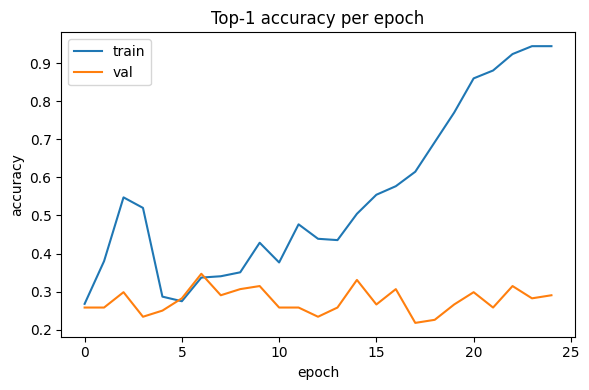

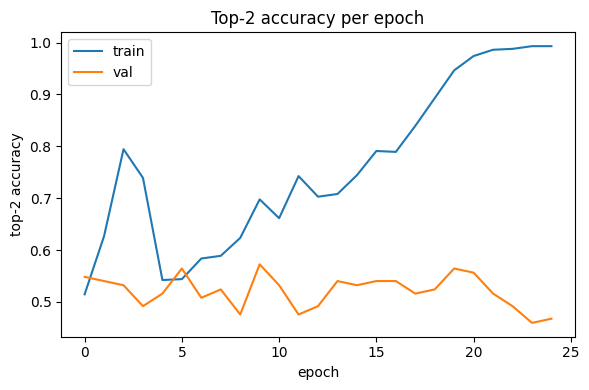

In [ ]:
# Loss
plt.figure(figsize=(6,4))
plt.plot(history_raw["train_loss"], label="train")
plt.plot(history_raw["val_loss"],   label="val")
plt.title("Loss per epoch"); plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

# Accuracy (top-1)
plt.figure(figsize=(6,4))
plt.plot(history_raw["train_acc"], label="train")
plt.plot(history_raw["val_acc"],   label="val")
plt.title("Top-1 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# Top-2
plt.figure(figsize=(6,4))
plt.plot(history_raw["train_top2"], label="train")
plt.plot(history_raw["val_top2"],   label="val")
plt.title("Top-2 accuracy per epoch"); plt.xlabel("epoch"); plt.ylabel("top-2 accuracy")
plt.legend(); plt.tight_layout(); plt.show()

# LR schedule across batches (OneCycle)
if history_raw["lrs"]:
    plt.figure(figsize=(6,3))
    plt.plot(history_raw["lrs"])
    plt.title("Learning rate (per batch)"); plt.xlabel("batch"); plt.ylabel("lr")
    plt.tight_layout(); plt.show()


In [15]:
model.load_state_dict(torch.load("best_raw.pt", map_location=device))
model.to(device).eval()

criterion = torch.nn.CrossEntropyLoss()

all_logits, all_targets = [], []
test_loss, top1_sum, top2_sum, total = 0.0, 0.0, 0.0, 0

with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for xb, yb in dl_test:   # dl_test debe entregar tensores normalizados igual que train/val
        xb = xb.to(device, non_blocking=True)    # yb se queda en CPU; está bien para sklearn
        logits = model(xb)                       # (B, C)

        # acumular para métricas globales
        all_logits.append(logits.cpu())
        all_targets.append(yb)

        # loss y top-k
        loss = criterion(logits.cpu(), yb)       # logits a CPU para usar el mismo yb
        test_loss += loss.item() * xb.size(0)
        preds_top1 = logits.argmax(dim=1).cpu()
        top1_sum += (preds_top1 == yb).float().sum().item()
        _, top2 = logits.topk(2, dim=1)          # en device
        top2 = top2.cpu()
        top2_sum += (top2.eq(yb.view(-1,1))).any(dim=1).float().sum().item()
        total += xb.size(0)

logits = torch.cat(all_logits)              # (N, C) en CPU
y_pred = logits.argmax(1).numpy()
y_true = torch.cat(all_targets).numpy()
y_prob = torch.softmax(logits, dim=1).numpy()

print({
    "loss": test_loss/total,
    "acc":  top1_sum/total,
    "top2": top2_sum/total,
})

# Ajusta el orden/nombres según tu label encoder
# Por ejemplo, si usaste este orden en el fit: ["ASD","Normal","PDA","VSD"]
target_names = ["ASD","Normal","PDA","VSD"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(confusion_matrix(y_true, y_pred))


/tmp/ipython-input-1916276467.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'loss': 1.3401953125, 'acc': 0.424, 'top2': 0.72}
              precision    recall  f1-score   support

         ASD     0.5769    0.4688    0.5172        32
      Normal     0.4118    0.2414    0.3043        29
         PDA     0.3710    0.6970    0.4842        33
         VSD     0.4000    0.2581    0.3137        31

    accuracy                         0.4240       125
   macro avg     0.4399    0.4163    0.4049       125
weighted avg     0.4404    0.4240    0.4087       125

[[15  3 12  2]
 [ 3  7 14  5]
 [ 0  5 23  5]
 [ 8  2 13  8]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


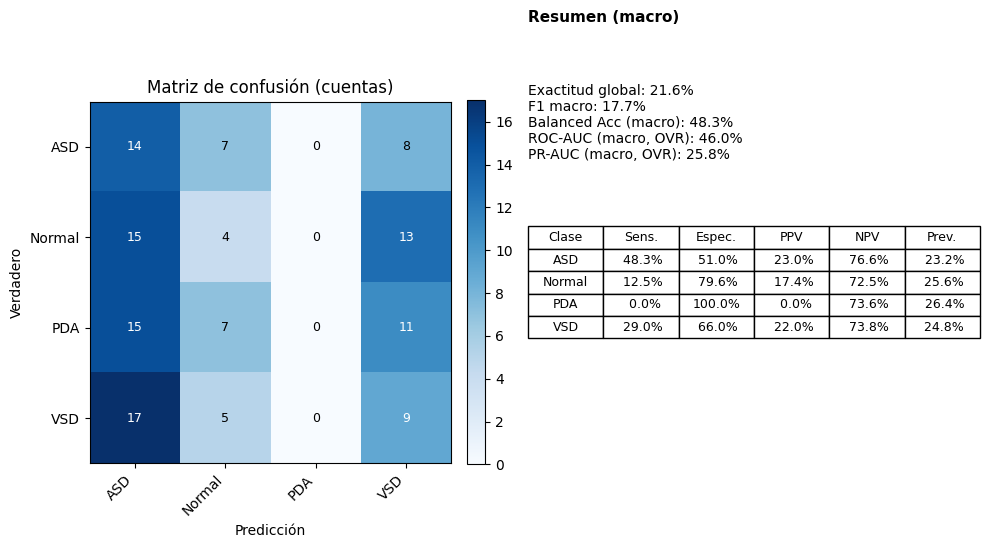

{'accuracy': 0.216, 'f1_macro': 0.17664141414141415, 'balanced_accuracy_macro': np.float64(0.4829714076022139), 'roc_auc_macro_ovr': np.float64(0.45954872892783194), 'pr_auc_macro_ovr': np.float64(0.2584993129268848)}


In [ ]:


C = len(target_names)

# --- Métricas base ---
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# One-vs-rest AUCs
try:
    roc_auc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
except Exception:
    roc_auc_macro = np.nan
try:
    pr_auc_macro  = average_precision_score(
        np.eye(C)[y_true], y_prob, average='macro'
    )
except Exception:
    pr_auc_macro = np.nan

# Balanced Accuracy macro = promedio de (sensibilidad y especificidad por clase, OVR)
# Calculamos también Sensibilidad/Especificidad/PPV/NPV por clase
per_class_rows = []
sens_list, spec_list = [], []
ppv_list,  npv_list  = [], []
prev_list = []

total = cm.sum()
for k, name in enumerate(target_names):
    tp = cm[k, k]
    fn = cm[k, :].sum() - tp
    fp = cm[:, k].sum() - tp
    tn = total - tp - fp - fn

    sens = tp / (tp + fn + 1e-12)      # recall
    spec = tn / (tn + fp + 1e-12)
    ppv  = tp / (tp + fp + 1e-12)      # precision
    npv  = tn / (tn + fn + 1e-12)
    prev = (tp + fn) / (total + 1e-12)

    sens_list.append(sens); spec_list.append(spec)
    ppv_list.append(ppv);   npv_list.append(npv)
    prev_list.append(prev)

    per_class_rows.append([
        name,
        f"{sens*100:5.1f}%",
        f"{spec*100:5.1f}%",
        f"{ppv*100:5.1f}%",
        f"{npv*100:5.1f}%",
        f"{prev*100:5.1f}%"
    ])

balanced_acc_macro = np.mean([(s + p)/2 for s, p in zip(sens_list, spec_list)])

f1_macro = float(report["macro avg"]["f1-score"])
acc_overall = float(report["accuracy"])

# Visual: matriz de confusión + tabla de métricas
fig = plt.figure(figsize=(10, 5.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1.05, 1.2])

# Panel 1: Confusion Matrix (counts)
ax1 = fig.add_subplot(gs[0,0])
im = ax1.imshow(cm, cmap="Blues")
ax1.set_title("Matriz de confusión (cuentas)")
ax1.set_xlabel("Predicción"); ax1.set_ylabel("Verdadero")

ticks = np.arange(C)
ax1.set_xticks(ticks); ax1.set_yticks(ticks)
ax1.set_xticklabels(target_names, rotation=45, ha="right")
ax1.set_yticklabels(target_names)

# anotar celdas
th = cm.max() / 2
for i in range(C):
    for j in range(C):
        ax1.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black", fontsize=9)
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# Panel 2: Tabla de métricas clínicas clave
ax2 = fig.add_subplot(gs[0,1])
ax2.axis('off')
col_labels = ["Clase", "Sens.", "Espec.", "PPV", "NPV", "Prev."]
table_data = per_class_rows

table = ax2.table(cellText=table_data,
                  colLabels=col_labels,
                  loc='center',
                  cellLoc='center',
                  colLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.0, 1.2)

# Encabezado de resumen macro
macro_text = (
    f"Exactitud global: {acc_overall*100:0.1f}%\n"
    f"F1 macro: {f1_macro*100:0.1f}%\n"
    f"Balanced Acc (macro): {balanced_acc_macro*100:0.1f}%\n"
    f"ROC-AUC (macro, OVR): {roc_auc_macro*100:0.1f}%\n"
    f"PR-AUC (macro, OVR): {pr_auc_macro*100:0.1f}%"
)
ax2.text(0.0, 1.05, "Resumen (macro)", fontsize=11, fontweight='bold', transform=ax2.transAxes)
ax2.text(0.0, 0.92, macro_text, fontsize=10, transform=ax2.transAxes, va='top')

plt.tight_layout()
plt.show()

# --- Impresión resumida en consola (opcional) ---
print({
    "accuracy": acc_overall,
    "f1_macro": f1_macro,
    "balanced_accuracy_macro": balanced_acc_macro,
    "roc_auc_macro_ovr": roc_auc_macro,
    "pr_auc_macro_ovr": pr_auc_macro
})


# **ANALISIS DE QUE FILTROS AFECTAN MÁS INTERNAMENTE (FEATURE ATTRIBUTION POR CANAL O POR CAPA)**


**Objetivo:** entender qué partes de la red y qué filtros contribuyen más a la clasificación dando una explicabilidad interna del modelo CNN

**Tecnicas a usar**

Implementamos tres técnicas de explicabilidad sobre el modelo ResNet18Gray evaluadas en el conjunto de validación.

1. Activaciones intermedias: visualizan los mapas de características por capa. Las capas tempranas resaltaron bordes y texturas; las capas profundas concentraron activaciones en regiones perihiliares/cardiacas y en la trama vascular, coherente con los biomarcadores esperados en PDA/VSD.

2. Atribución por canal en la última convolución: calculamos el gradiente medio espacial por filtro para la clase objetivo y obtuvimos un ranking de canales influyentes. Los canales TOP muestran feature maps con alta respuesta en zonas anatómicamente relevantes, lo que sugiere que la red se apoya en patrones vasculares centrales para discriminar clases.

3. Integrated Gradients: generamos mapas de contribución a nivel píxel, evidenciando que los píxeles con mayor peso se ubican principalmente en regiones perihiliares y cardiomediastínicas. Esto refuerza que el modelo utiliza señales clínicamente plausibles y no artefactos espurios.

**Puntos clave**

- Dataset usado: conjunto de validación (X_val_normalized) para evaluar atribución en datos no vistos durante el entrenamiento.
- Las activaciones tempranas detectan bordes y texturas; las tardías concentran patrones anatómicos (perihiliar/cardiomediastínico).
- La importancia por canal en la última conv revela filtros dominantes por clase (gráficas TOP-10 por clase).
- Integrated Gradients tendria que mostrar que, para predicciones correctas, las contribuciones se concentran en regiones pulmonares centrales/perihiliares, coherentes con cambios vasculares esperados en PDA/VSD/ASD.

### Visualizacion de activaciones Intermedias por capa/filtro

Objetivo: ver qué patrones detecta la red en distintas profundidades, mostrar qué detectan los filtros (bordes, texturas, vasculatura) en distintas profundidades.

Tomar en cuenta:
- Capas tempranas, bordes, contornos, texturas locales.
- Capas profundas, patrones más globales/anatómicos (trama vascular, regiones perihiliares, contornos cardíacos).
- Limitaciones: es cualitativo. No te dice “qué canal es más importante”, sino qué está detectando cada canal.

Cómo interpretarlo:

- Activaciones fuertes en bordes/ruido en layer1/2, es normal.

- En layer3/4, nos interesan que aparezcan activaciones en zonas clínicamente relevantes (perihiliares/cardiacas o distribución vascular), lo que sugiere que la red está aprendiendo señales útiles para ASD/PDA/VSD vs NORMAL.

Limitaciones: es cualitativo. No nos dice “qué canal es más importante”, sino qué está detectando cada canal.

### **Activaciones por clase**

In [46]:
import numpy as np, torch, matplotlib.pyplot as plt
from collections import OrderedDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# --- Hooks sobre el backbone real: model.net.layerX ---
target_layers = OrderedDict([
    ('layer1', model.net.layer1),
    ('layer2', model.net.layer2),
    ('layer3', model.net.layer3),
    ('layer4', model.net.layer4),
])

activations = {}
def get_activation_hook(name):
    def hook(module, inp, out):
        activations[name] = out.detach().cpu()  # (B,C,H,W)
    return hook

hooks = [layer.register_forward_hook(get_activation_hook(n)) for n, layer in target_layers.items()]
with torch.no_grad():
    _ = model(x_t)
for h in hooks: h.remove()

def plot_feature_grid(feat, title, max_channels=16):
    C = min(feat.shape[1], max_channels)
    cols = 8; rows = int(np.ceil(C/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
    axes = axes.ravel()
    for i in range(rows*cols):
        axes[i].axis('off')
        if i < C:
            axes[i].imshow(feat[0, i].numpy(), cmap='viridis')
            axes[i].set_title(f'ch {i}', fontsize=8)
    fig.suptitle(title, fontsize=14); plt.tight_layout(); plt.show()


==== Clase: NORMAL | idx 109 ====


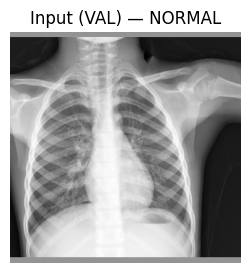

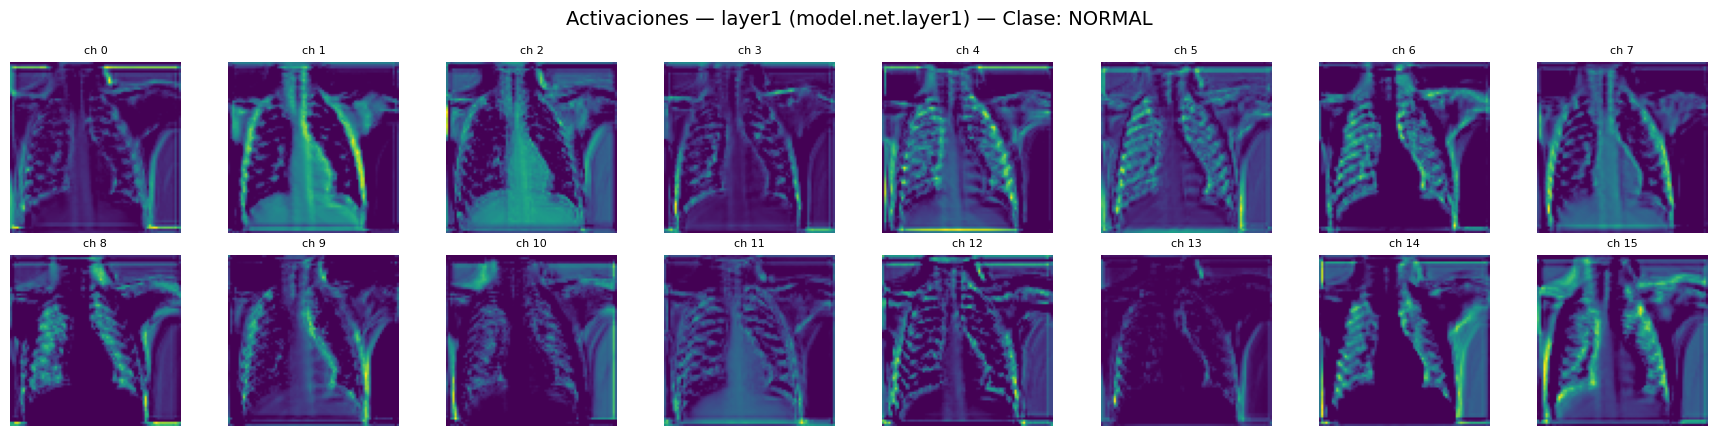

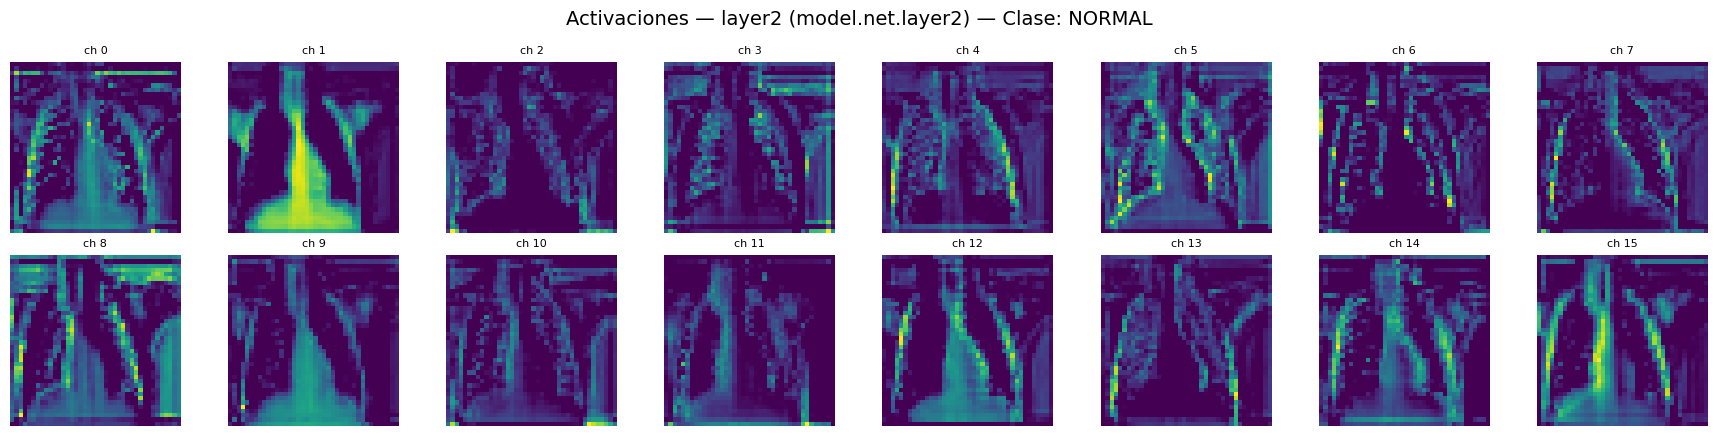

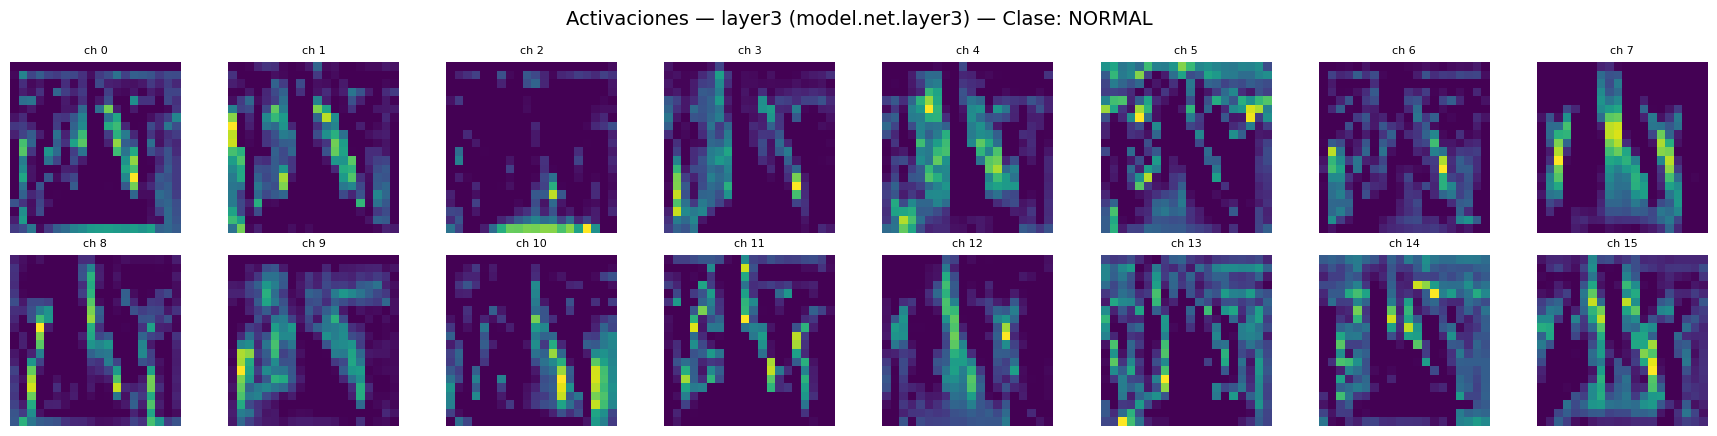

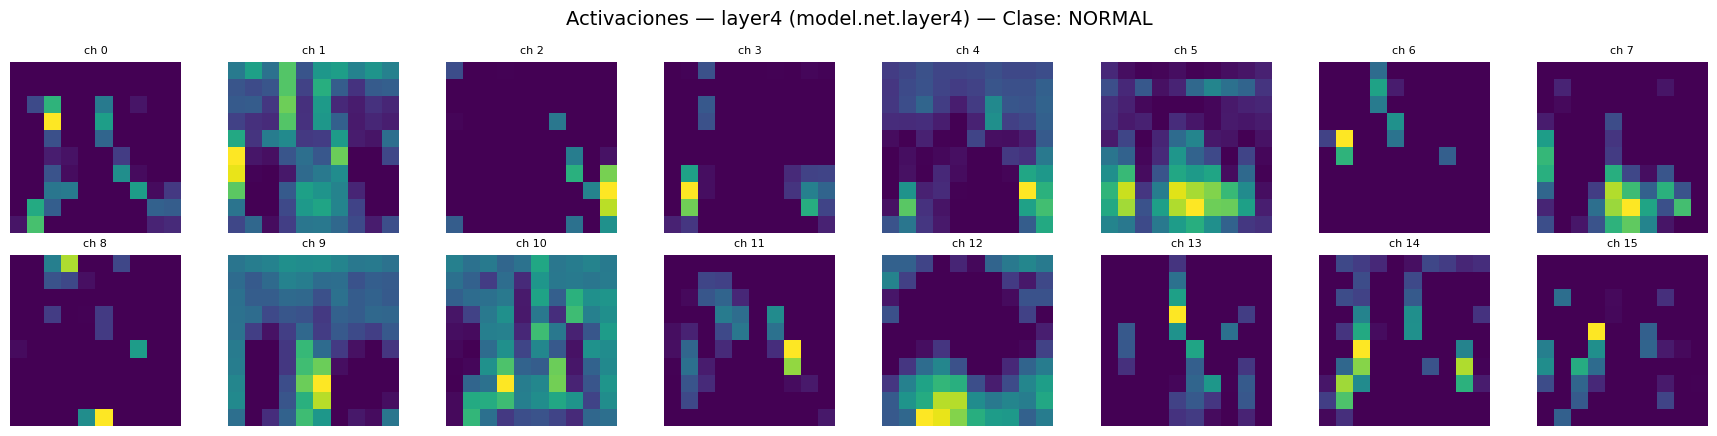


==== Clase: ASD | idx 37 ====


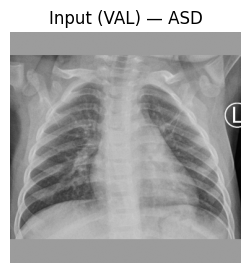

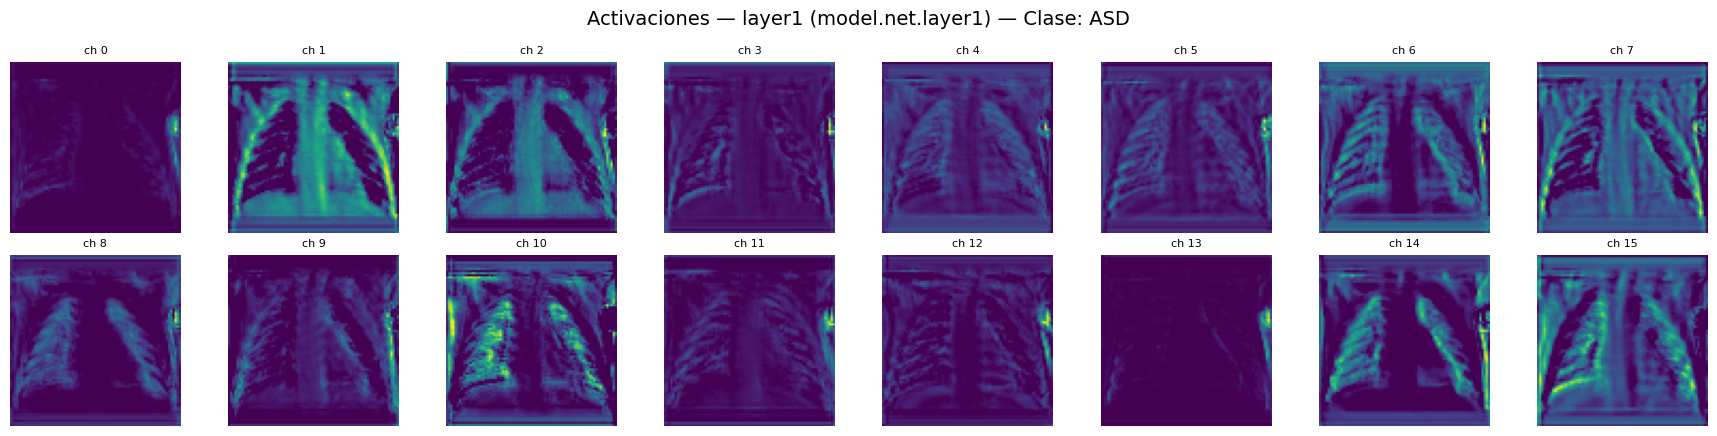

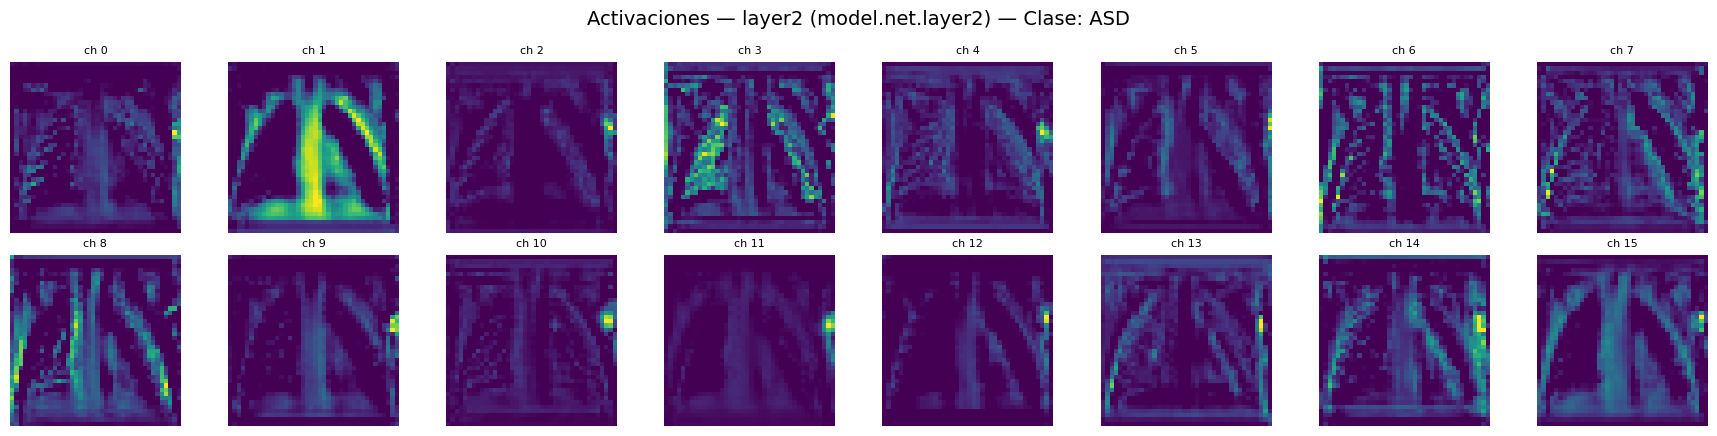

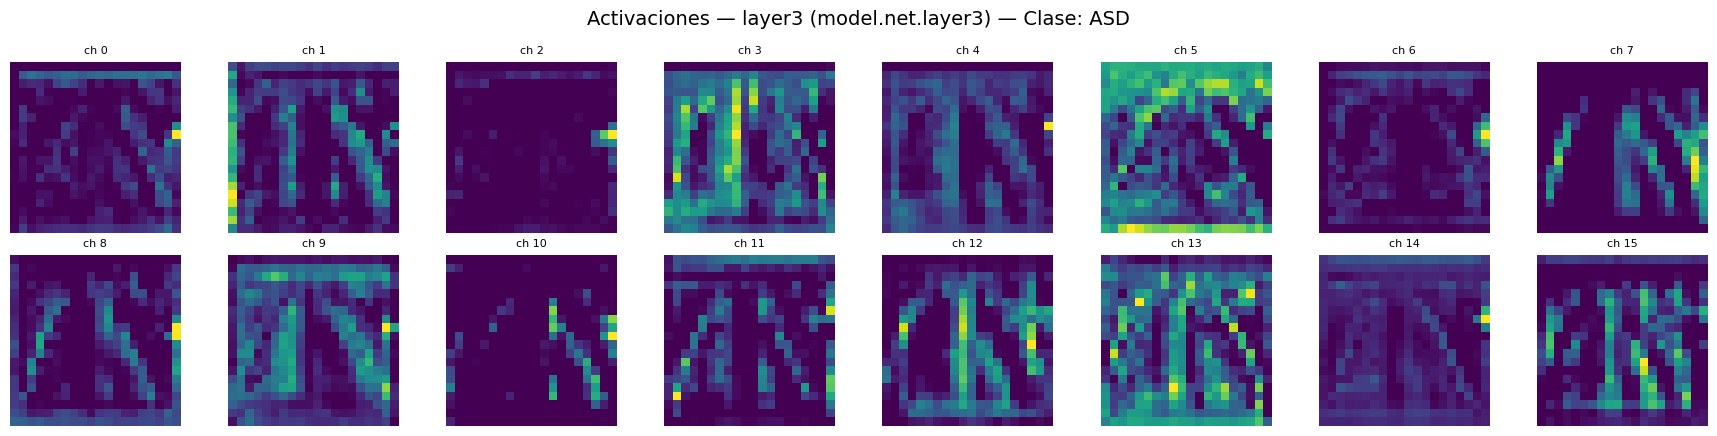

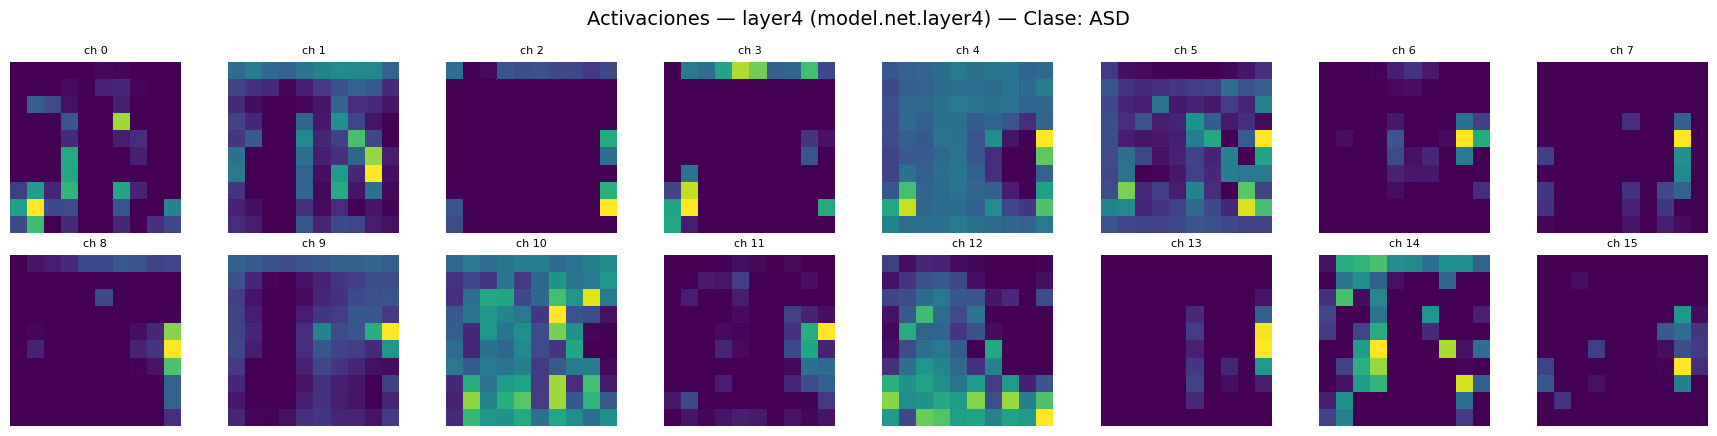


==== Clase: PDA | idx 87 ====


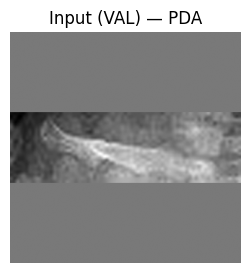

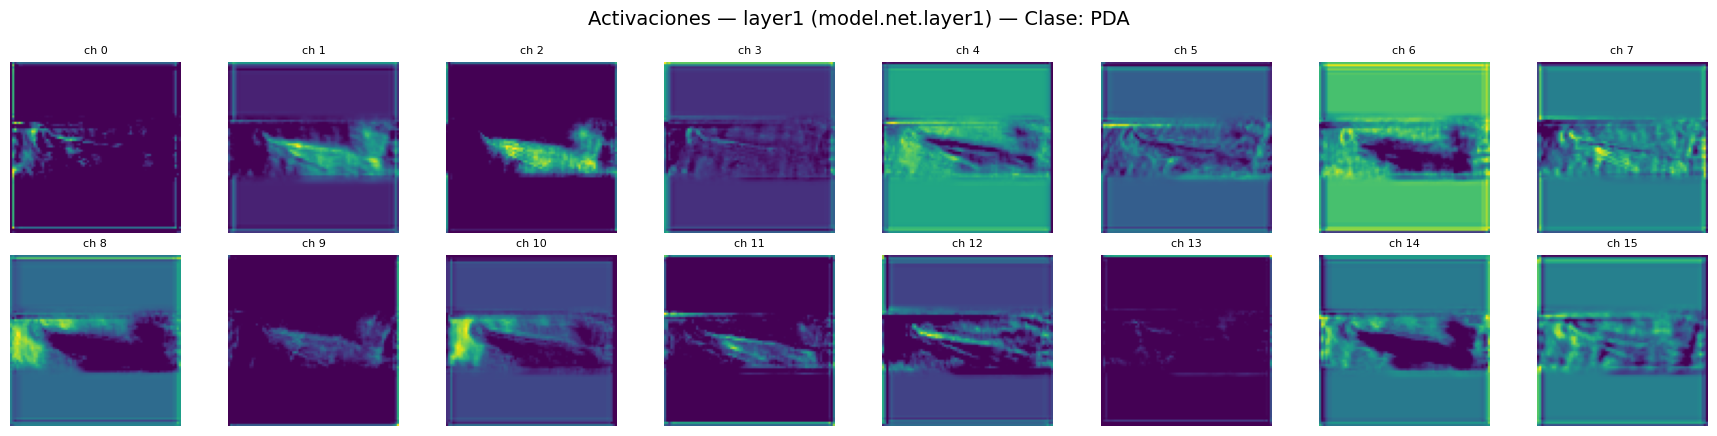

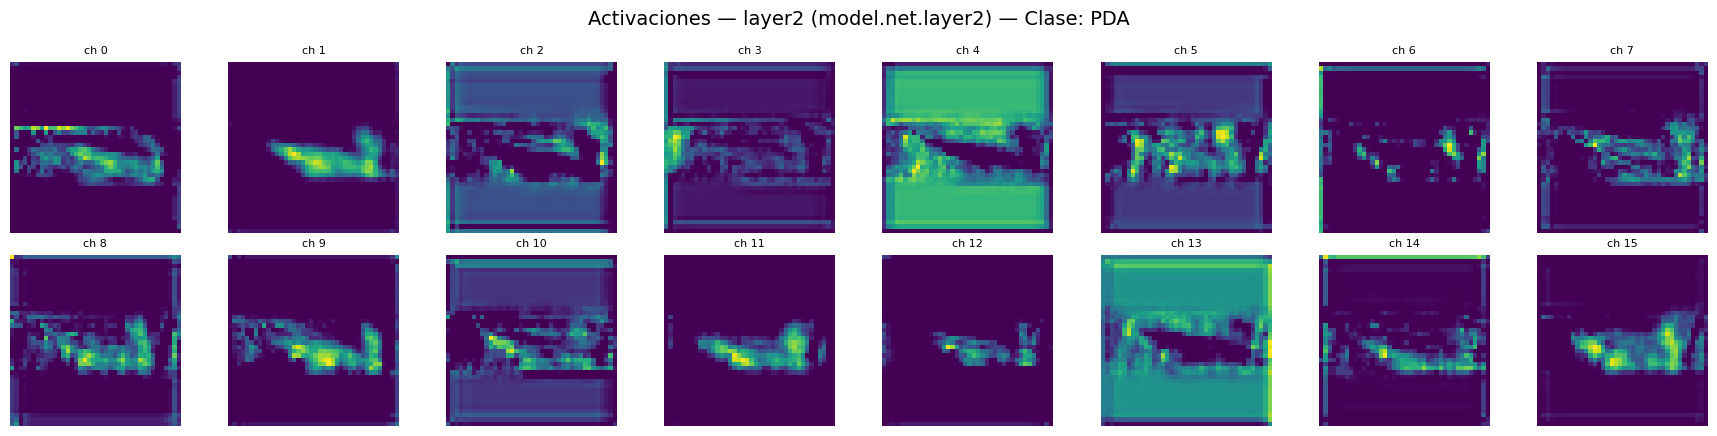

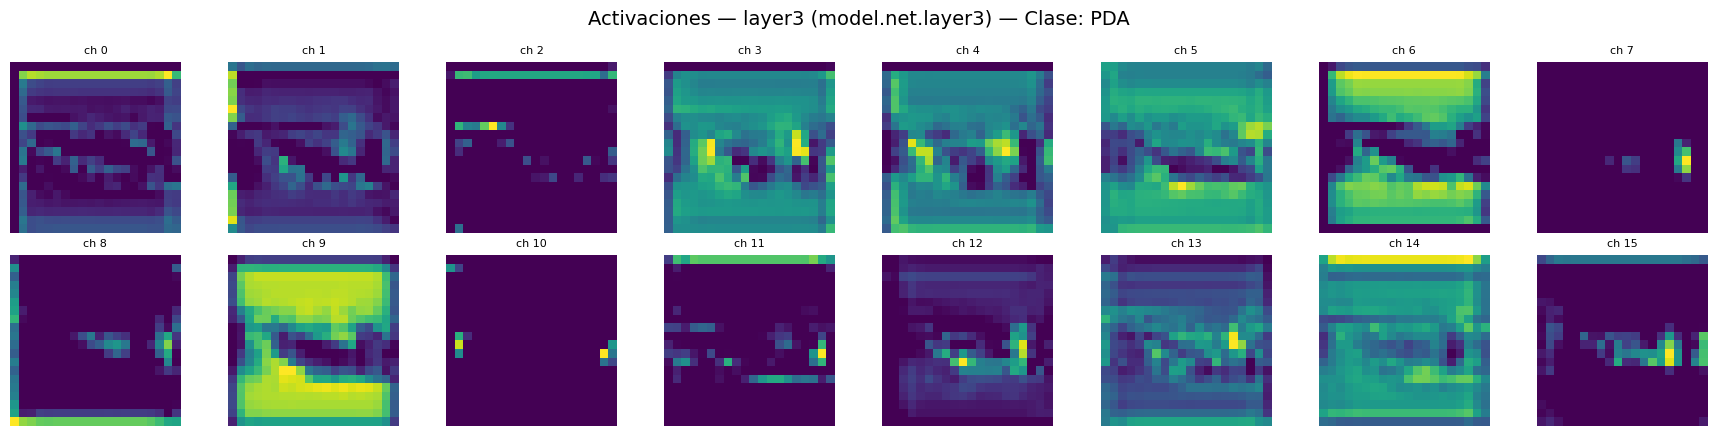

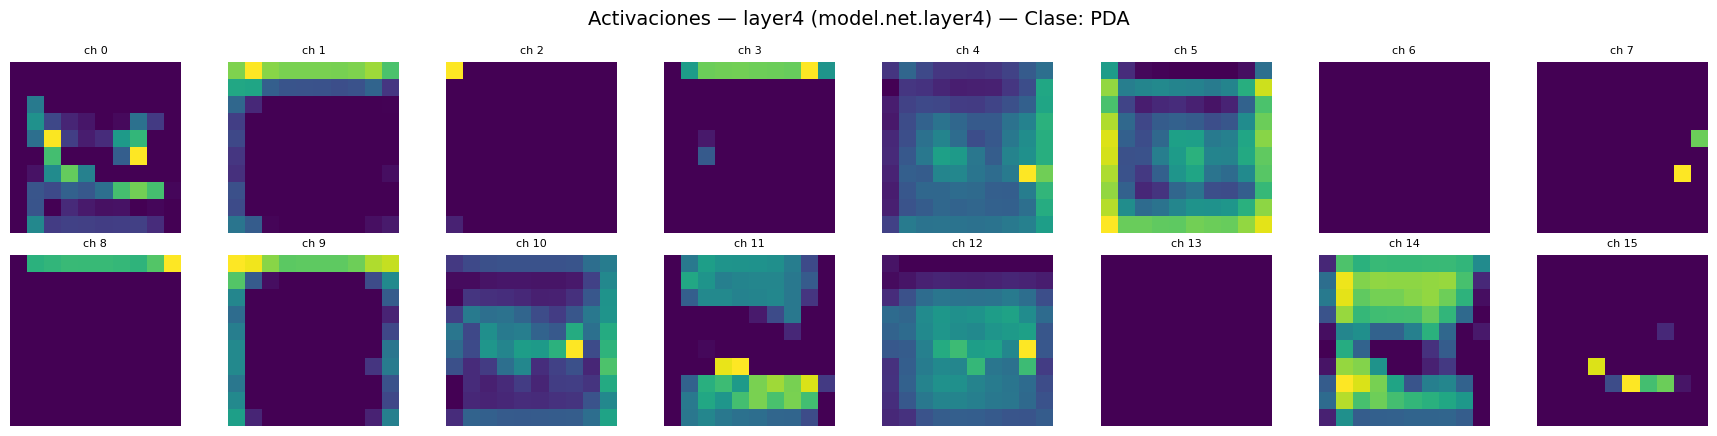


==== Clase: VSD | idx 85 ====


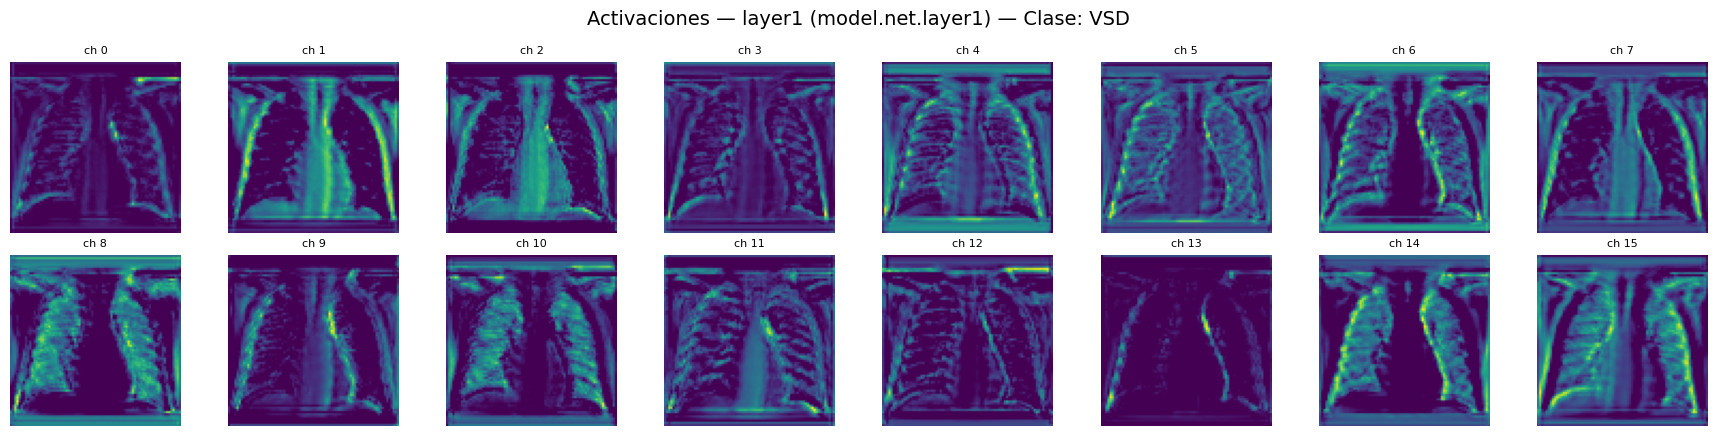

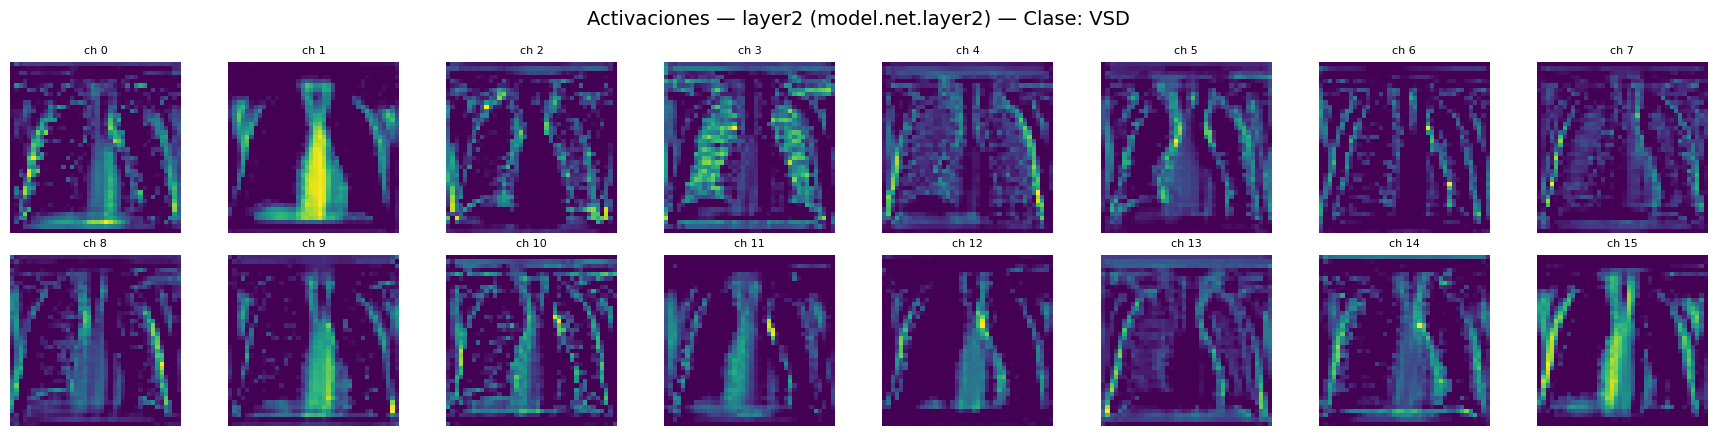

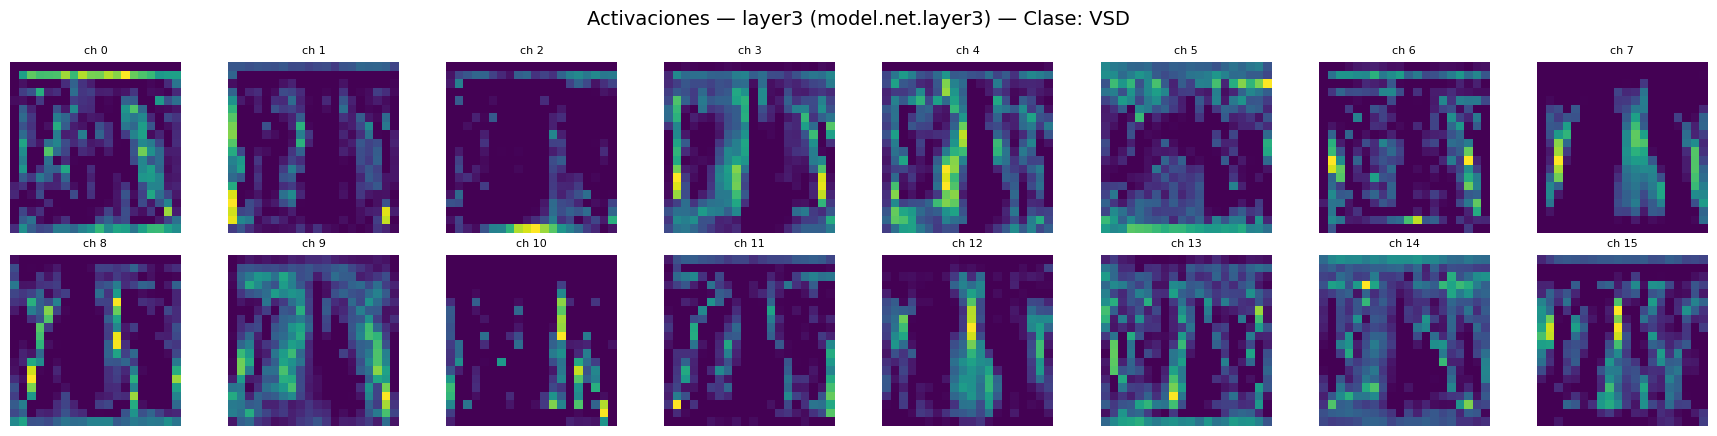

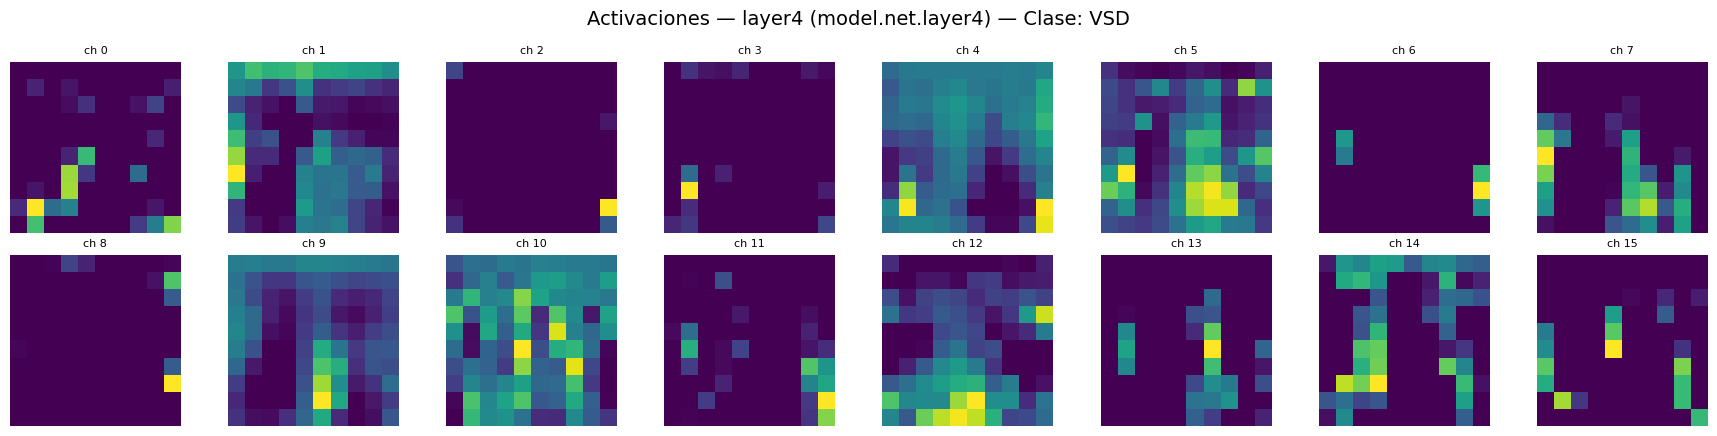

In [47]:
# ==============================================
# VISUALIZAR ACTIVACIONES POR CLASE (VALIDACIÓN)
# ==============================================

# --- Asegurar que class_names exista ---
if 'class_names' not in locals():
    # Ajusta el orden según tu codificación one-hot en Y_val_encoded
    class_names = ['NORMAL', 'ASD', 'PDA', 'VSD']

# --- Helper: ejecutar forward y recolectar activaciones ---
def get_activations_for_image(x_np):
    """
    Corre el modelo para una imagen y retorna las activaciones de tus capas target_layers
    """
    # convertir a tensor normalizado (igual que en tu pipeline)
    x_t_local = torch.from_numpy(
        ((x_np.transpose(2,0,1)[None, ...]) - mean_tr) / (std_tr + 1e-8)
    ).float().to(device)

    local_activations = {}
    def hook_fn(name):
        def hook(module, inp, out):
            local_activations[name] = out.detach().cpu()
        return hook

    # registrar hooks con nombres correctos
    hooks_tmp = []
    for n, layer in target_layers.items():
        hooks_tmp.append(layer.register_forward_hook(hook_fn(n)))

    # forward
    with torch.no_grad():
        _ = model(x_t_local)

    # eliminar hooks
    for h in hooks_tmp:
        h.remove()

    return local_activations

# --- Obtener una imagen aleatoria por clase y mostrar activaciones ---
y_val_idx = np.argmax(Y_val_encoded, axis=1)
num_classes = Y_val_encoded.shape[1]

for c in range(num_classes):
    idxs = np.where(y_val_idx == c)[0]
    if len(idxs) == 0:
        print(f"[{class_names[c]}] sin muestras en validación, se omite.")
        continue

    sample_idx = int(np.random.choice(idxs))
    x_np_cls = X_val_normalized[sample_idx]

    print(f"\n==== Clase: {class_names[c]} | idx {sample_idx} ====")
    plt.figure(figsize=(3,3))
    plt.imshow(x_np_cls[:,:,0], cmap='gray')
    plt.title(f'Input (VAL) — {class_names[c]}')
    plt.axis('off')
    plt.show()

    # obtener activaciones
    acts_cls = get_activations_for_image(x_np_cls)

    # graficar activaciones para las capas presentes
    for name in ['layer1','layer2','layer3','layer4']:
        if name in acts_cls:
            plot_feature_grid(
                acts_cls[name],
                f'Activaciones — {name} (model.net.{name}) — Clase: {class_names[c]}',
                max_channels=16
            )
        else:
            print(f"[Aviso] No se encontró {name} en las activaciones.")


## Atribución cuantitativa por canal (Ranking de filtros) (por canal o capa)

Atribución cuantitativa por canal (gradientes medios en la última capa conv).

Calcula qué filtros (canales) de la última capa convolucional más contribuyen a la clase predicha. Luego agregamos un resumen por clase usando varias imágenes de validación.

Cómo interpretarlo:

- Barras más altas = filtros más influyentes para esa predicción.

- Si los feature maps de esos canales TOP iluminan la región perihiliar o patrones vasculares, es buena señal (alineado a la hipótesis clínica de hiperflujo en PDA/VSD).

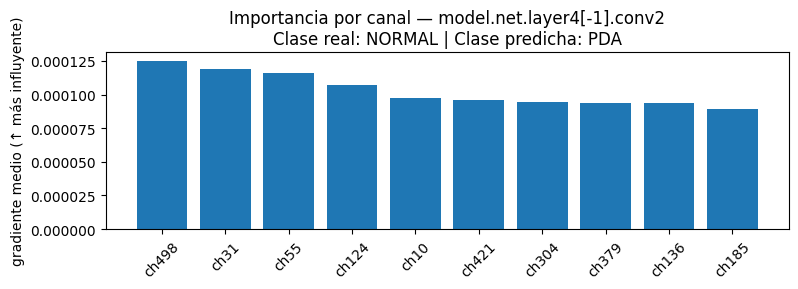

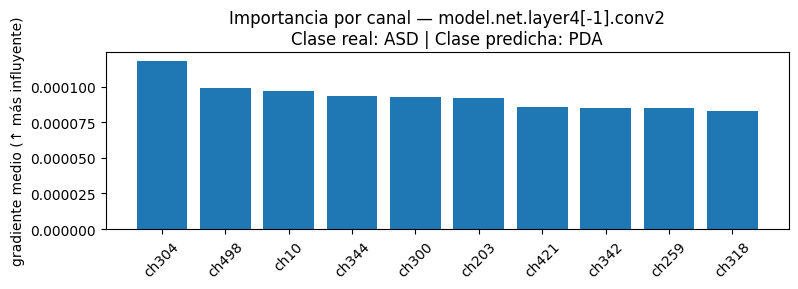

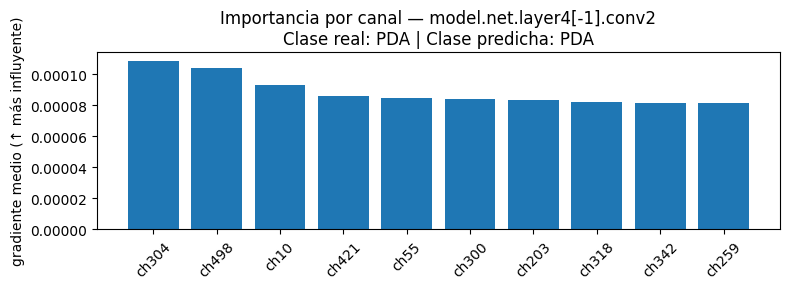

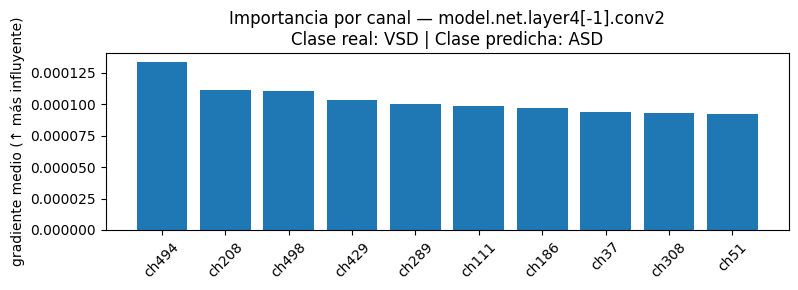

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Detectar última capa conv del backbone
try:
    last_conv_module = model.net.layer4[-1].conv2
    last_name = 'model.net.layer4[-1].conv2'
except Exception:
    last_conv_module = model.net.layer4
    last_name = 'model.net.layer4'

# Asegurar nombres de clase (ajusta si tu one-hot tiene otro orden)
if 'class_names' not in locals():
    class_names = ['NORMAL', 'ASD', 'PDA', 'VSD']

# Helper: preparar tensor normalizado a partir de x_np (H,W,1) en [0,1]
def to_tensor_norm(x_np):
    x_t_local = torch.from_numpy(
        ((x_np.transpose(2,0,1)[None, ...]) - mean_tr) / (std_tr + 1e-8)
    ).float().to(device)
    return x_t_local

# Función: importancia por canal para UNA imagen (x_np) con hooks locales
def channel_importance_single(x_np):
    feat_maps_global = None
    grads_global = None

    def fwd_hook(module, input, output):
        nonlocal feat_maps_global
        feat_maps_global = output.detach()

    def bwd_hook(module, grad_input, grad_output):
        nonlocal grads_global
        grads_global = grad_output[0].detach()

    # Registrar hooks
    h1 = last_conv_module.register_forward_hook(fwd_hook)
    h2 = last_conv_module.register_full_backward_hook(bwd_hook)

    x_t_local = to_tensor_norm(x_np)
    model.zero_grad()
    logits = model(x_t_local)                 # (1, num_classes)
    pred_idx = int(torch.argmax(logits, dim=1))
    loss = logits[0, pred_idx]
    loss.backward()

    # Remover hooks
    h1.remove(); h2.remove()

    # Importancia por canal = promedio espacial de gradientes
    ch_imp = grads_global.mean(dim=(0,2,3)).cpu().numpy()   # (C,)
    return ch_imp, pred_idx

# Loop por clase: elegir una muestra de validación de cada clase y graficar TOP-K
y_val_idx = np.argmax(Y_val_encoded, axis=1)
num_classes = Y_val_encoded.shape[1]

for c in range(num_classes):
    idxs = np.where(y_val_idx == c)[0]
    if len(idxs) == 0:
        print(f"[{class_names[c]}] no hay muestras en validación; se omite.")
        continue

    sample_idx = int(np.random.choice(idxs))
    x_np_cls = X_val_normalized[sample_idx]  # (H,W,1) en [0,1]

    ch_imp, pred_idx = channel_importance_single(x_np_cls)

    # Graficar ranking TOP-10
    top_k = min(10, ch_imp.shape[0])
    top_idx = np.argsort(-ch_imp)[:top_k]

    plt.figure(figsize=(8,3))
    plt.bar(range(top_k), ch_imp[top_idx])
    plt.xticks(range(top_k), [f'ch{j}' for j in top_idx], rotation=45)
    plt.title(f'Importancia por canal — {last_name}\nClase real: {class_names[c]} | Clase predicha: {class_names[pred_idx] if pred_idx < len(class_names) else pred_idx}')
    plt.ylabel('gradiente medio (↑ más influyente)')
    plt.tight_layout()
    plt.show()


Interpretacion: El valor en el eje Y es el gradiente medio espacial, que indica cuánto influye ese canal en la predicción final de la red.
Cuanto mayor sea el valor, mayor peso tiene ese canal para la decisión.


**Clase NORMAL**
- Se observa que canales como ch498, ch31 y ch55 dominan la salida.

- Estos filtros parecen ser sensibles a patrones de contraste difuso o estructuras vasculares que, aunque presentes en casos normales, pueden asemejarse a hiperflujo pulmonar.

- Esto podria explicar la posible confusión con PDA: el modelo sobre-interpreta características vasculares leves en un tórax normal.

Hipotesis: el modelo está sesgado hacia detectar vasos pulmonares aun en radiografías normales, señalando posible sobre-sensibilidad a textura vascular central. <br>

**Clase ASD --> Predicha como PDA**
- Los canales con mayor peso son ch304 y ch498, los mismos que también aparecen en la clase PDA.
- Esta superposición sugiere que el modelo usa los mismos filtros para ambos defectos, porque ambas cardiopatías muestran cierto aumento del flujo pulmonar.
- El gradiente de los demás canales es más uniforme → el modelo no logra distinguir rasgos diferenciales entre ASD y PDA.

CONCLUSION: el modelo reconoce la presencia de hiperflujo pero no logra capturar la diferencia anatómica (posición y morfología del cortocircuito).<br>


**Clase PDA , Predicha correctamente (PDA)**
- Vuelve a dominar ch304 y ch498, pero ahora su magnitud está más equilibrada y acompañada por otros canales (ch10, ch421, ch55…).
- Esto indica una activación distribuida de varios filtros complementarios, lo que suele asociarse a mayor confianza en la predicción.
- Los canales activos corresponden, según observaciones del punto 1, a regiones perihiliares y cardiacas, donde el patrón vascular es más denso.

CONSLUSION: Creemos que en casos PDA verdaderos, el modelo usa un conjunto estable de filtros especializados en la vasculatura central tomando asi una decisión correcta.


**Clase VSD - Predicha como ASD**
- Los canales más influyentes (ch494, ch208, ch498) son distintos a los de PDA, pero ch498 vuelve a aparecer, indicando cierto solapamiento.
- Esto sugiere que el modelo asocia VSD con patrones similares a ASD, probablemente por la distribución vascular bilateral.
- El canal ch494 —el más alto— podría estar capturando asimetrías cardiacas o aumento del tamaño ventricular, pero sin peso suficiente para marcarlo como VSD.

CONCLUSION: Vemos que el modelo confunde VSD y ASD, probablemente por compartir morfología de hiperflujo, sin distinguir la localización precisa del cortocircuito.


## Integrated Gradients (IG) a nivel píxel - PyTorch

Estima la contribución de cada píxel de la entrada a la predicción, de forma más robusta que un gradiente directo (reduce problemas de saturación). Produce un mapa de atribución directamente en la entrada, robusto a saturación de gradientes.

Cómo interpretarlo:

- Zonas rojas/azules intensas = píxeles con mayor peso (positivo/negativo) para la decisión.

- Si la contribución se concentra en región perihiliar y distribución vascular (en lugar de costillas/bordes/artefactos), eso apoya que el modelo usa señales clínicas plausibles.

Limitaciones: depende de la baseline elegida; no identifica canales internos (es atribución en entrada).

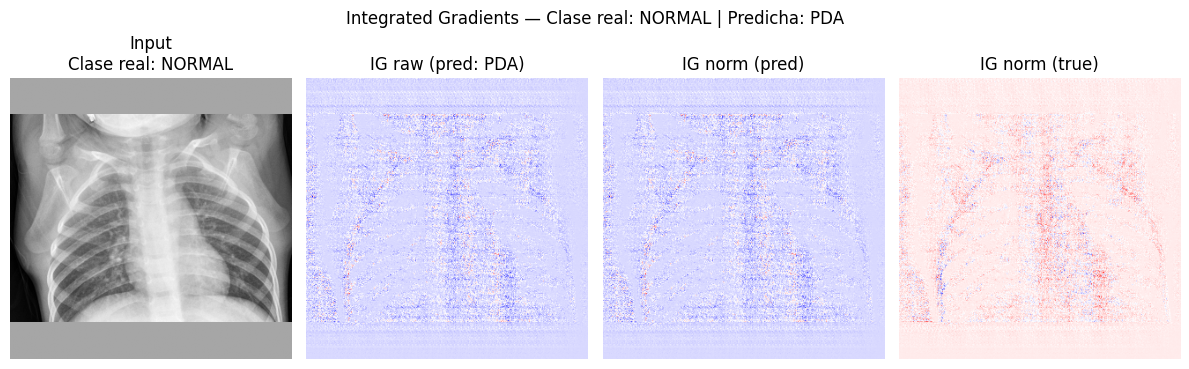

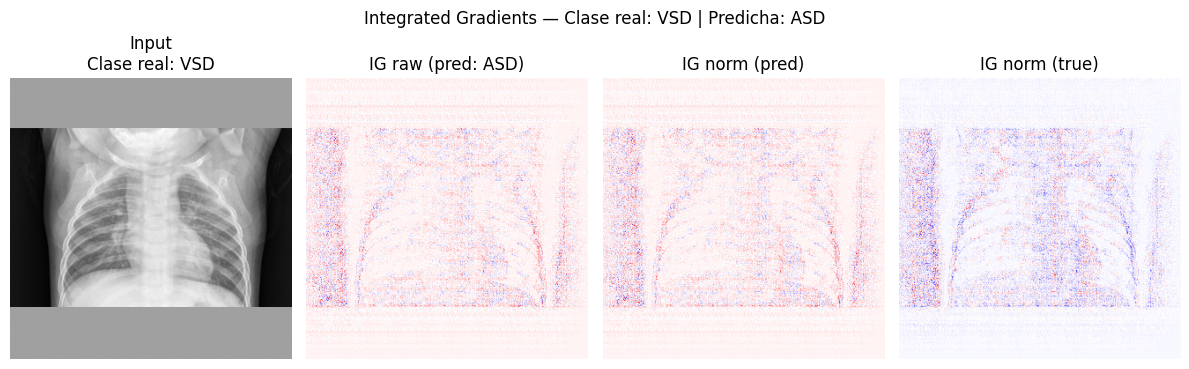

In [43]:
# ============================================
# INTEGRATED GRADIENTS (IG) — POR CLASE (VALIDACIÓN)
# ============================================
import torch, numpy as np, matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# --- Si no tienes nombres de clase definidos, crea unos por defecto ---
if 'class_names' not in locals():
    class_names = ['NORMAL', 'ASD', 'PDA', 'VSD']  # ajusta si tu one-hot tiene otro orden

# --- Helper: normalizar como en tu pipeline ---
def to_tensor_norm(x_np):
    # x_np: (H, W, 1) en [0,1]
    x_t = torch.from_numpy(x_np).permute(2,0,1).unsqueeze(0).float()  # (1,1,H,W)
    # mean_tr y std_tr pueden ser float o tensor; broadcast a (1,1,1,1)
    mt = mean_tr if torch.is_tensor(mean_tr) else torch.tensor(mean_tr, dtype=torch.float32)
    st = std_tr  if torch.is_tensor(std_tr)  else torch.tensor(std_tr,  dtype=torch.float32)
    mt = mt.view(1,1,1,1).to(device)
    st = st.view(1,1,1,1).to(device)
    x_t = x_t.to(device)
    x_t = (x_t - mt) / (st + 1e-8)
    return x_t

# --- IG base (tu misma función) ---
def integrated_gradients(model, x, target_index=None, baseline=None, steps=64):
    model.eval()
    x = x.clone().detach().requires_grad_(True)
    if baseline is None:
        baseline = torch.zeros_like(x).to(x.device)

    with torch.no_grad():
        logits = model(x)
    if target_index is None:
        target_index = int(torch.argmax(logits, dim=1))

    alphas = torch.linspace(0, 1, steps+1, device=x.device).view(-1,1,1,1)
    x_scaled = baseline + alphas * (x - baseline)
    x_scaled.requires_grad_(True)
    scores = model(x_scaled)[:, target_index]
    grads = torch.autograd.grad(scores, x_scaled, grad_outputs=torch.ones_like(scores), only_inputs=True)[0]
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = grads.mean(dim=0, keepdim=True)
    ig = (x - baseline) * avg_grads
    return ig.detach()

# --- Seleccionar UNA muestra por clase (VALIDACIÓN) y graficar IG (predicha y verdadera) ---
y_val_idx = np.argmax(Y_val_encoded, axis=1)
num_classes = Y_val_encoded.shape[1]

for c in range(num_classes):
    idxs = np.where(y_val_idx == c)[0]
    if len(idxs) == 0:
        print(f"[{class_names[c]}] sin muestras en validación, se omite.")
        continue

    sample_idx = int(np.random.choice(idxs))
    x_np = X_val_normalized[sample_idx]  # (H,W,1) en [0,1]
    x_t  = to_tensor_norm(x_np)

    with torch.no_grad():
        logits = model(x_t)
    pred_idx = int(torch.argmax(logits, dim=1))

    # --- IG para clase PREDICHA ---
    ig_pred = integrated_gradients(model, x_t, target_index=pred_idx, steps=64)
    igp = ig_pred[0,0].detach().cpu().numpy()
    igp_norm = igp / (np.max(np.abs(igp)) + 1e-12)

    # --- IG para clase VERDADERA (útil si difiere de la predicción) ---
    ig_true = integrated_gradients(model, x_t, target_index=c, steps=64)
    igt = ig_true[0,0].detach().cpu().numpy()
    igt_norm = igt / (np.max(np.abs(igt)) + 1e-12)

    # --- Mostrar resultados ---
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(x_np[:,:,0], cmap='gray'); plt.title(f'Input\nClase real: {class_names[c]}'); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(igp, cmap='bwr'); plt.title(f'IG raw (pred: {class_names[pred_idx] if pred_idx < len(class_names) else pred_idx})'); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(igp_norm, cmap='bwr'); plt.title('IG norm (pred)'); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(igt_norm, cmap='bwr'); plt.title('IG norm (true)'); plt.axis('off')
    plt.suptitle(f'Integrated Gradients — Clase real: {class_names[c]} | Predicha: {class_names[pred_idx] if pred_idx < len(class_names) else pred_idx}', fontsize=12)
    plt.tight_layout()
    plt.show()


### Integrated Gradients (IG) calcula la contribución de cada píxel a la salida del modelo:

Colores azules, contribuyen positivamente a la predicción (zonas que impulsan esa clase).

Colores rojos, contribuyen negativamente (zonas que la contradicen).

Las versiones “IG norm (pred)” y “IG norm (true)” permiten comparar la atención del modelo en la clase que predijo y en la clase que debería haber elegido.

**Clase REAL: NORMAL - Predicha: PDA**

Observaciones:
- El mapa “IG norm (pred)” muestra activación azul intensa en el mediastino y campos pulmonares medios, zonas típicas de patrón vascular.
- En “IG norm (true)” (NORMAL), la respuesta es mucho más difusa y débil, indicando que el modelo no aprendió un patrón característico para la clase NORMAL.

Interpretación:

- El modelo tiende a buscar estructuras vasculares y cardiacas incluso en casos normales, lo que explica la confusión con PDA.
- Los filtros dominantes vistos en el punto 2 (ej. ch498) están respondiendo aquí a textura vascular leve → falso positivo.

CONSLUSION: el modelo carece de una representación clara de “normalidad” y confunde patrones de flujo fisiológico con señales patológicas leves. <br>
<BR>

**Clase REAL: ASD - Predicha: PDA**

Observaciones:
- “IG raw / IG norm (pred)” muestran activación dispersa en regiones pulmonares y el área central, con escasa diferenciación anatómica.
- “IG norm (true)” (ASD) aparece roja casi completa, lo que indica que los gradientes para la clase verdadera se oponen al patrón que el modelo utiliza para PDA.

Interpretación:
- El modelo no logra identificar las diferencias sutiles en la distribución de vascularidad entre ASD y PDA.
- La atención se mantiene centrada en ambas bases pulmonares, sin discriminación del arco aórtico ni de la silueta cardiaca izquierda, que son más relevantes para ASD.

CONCLUSION: el modelo reconoce la presencia de hiperflujo, pero no logra capturar su localización o extensión, confundiendo ASD con PDA por patrones comunes de sobrecarga circulatoria.<BR>
<BR>


**Clase REAL: PDA - Predicha: PDA**

Observaciones:
- Las tres imágenes de IG son consistentes, con activación simétrica en zonas perihiliares y cardiacas.

- Las áreas azules (contribución positiva) se alinean con los vasos pulmonares centrales y el borde izquierdo del corazón.

Interpretación:

- Esta coherencia entre pred y true refleja que el modelo ha aprendido un patrón interno estable para PDA.
- Se confirma lo observado en el punto 2: cuando la red clasifica correctamente, utiliza varios filtros complementarios distribuidos espacialmente.

CONCLUSION: PDA es la clase mejor aprendida; el modelo asocia correctamente el aumento de flujo perihiliar con esta cardiopatía. <BR>
<BR>


**Clase REAL: VSD - Predicha: ASD**

Observaciones:
- Las activaciones aparecen bilaterales en los campos pulmonares y con contribución mixta (rojo y azul) en la región central.
- “IG norm (true)” (VSD) muestra un patrón opuesto, donde los píxeles que deberían favorecer VSD son atenuados en la predicción.

Interpretación:
- Tanto VSD como ASD producen aumento del flujo pulmonar y cardiomegalia leve, lo que genera zonas de atención similares.
- El modelo no distingue bien las diferencias de asimetría ventricular o grado de dilatación cardiaca, que suelen diferenciar clínicamente VSD y ASD.

CONSLUSION: el modelo confunde ambas patologías por similitud de patrones vasculares y falta de sensibilidad a los rasgos morfológicos del ventrículo.